# Coursework 1: Learning Learning, From Scratch

_COMP0169 Team_

__Niloy J. Mitra & Tobias Ritschel__

TAs:  __Sanjeev Muralikrishnan, Remy Sabathier & Maria Stamatopoulou__

The total points for this exercise is 100.

Please refer to Moodle submission page for the due date.


## Submission instructions:

Coursework submissions must comprise of a zipped folder. Inside this zip, you should have two things.


1.   This Jupyter notebook, containing your code and written comments.
2.   A "models/" folder, containing your trained model weights.


 In the notebook, cells that need to be changed are clearly stated with a &#9998; symbol and you are not allowed to change the rest of the code in any way. Descriptive answers must be contained in the markdown blocks starting with "_Your reply_:". Code must only be written in the space inside the `#begin_solution ... #end_solution` blocks. Code written outside these blocks will not be processed or evaluated.

Please, do not change `#begin_test ... #end_test` blocks, these blocks are for TAs.

Each exercise must be implemented from scratch. Unless differently specified, only numpy and matplotlib are allowed. The libraries are imported in [the package cell](#packages) and cannot be modified.



**Questions:**

[Question 1](#question1): Linear Fitting (10 points)

[Question 2](#question2): PCA (12 points)

[Question 3](#question3): Linear Classification (18 points)

[Question 4](#question4): Image Denoising (30 points)

[Question 5](#question5): Neural Implicit Representation (30 points)

## Datasets

We will be using several datasets for the coursework: _IRIS_ , _MNIST_ , _CelebA_ , _NoisyOCR_.

_IRIS_ and _MNIST_ datasets will be downloaded directly in the notebook using the `skdataset` library. Keep in mind that you will need to be connected to Internet to be able to download the datasets. If you want to work offline, you are free to save your dataset to npy file locally and load them while offline although this is not officially supported.

_CelebA_ and _NoisyOCR_ are provided separately in a zip file; make sure to unzip it and the unzipped folder is placed in the same directory as the notebook.


**_IRIS_**: The _IRIS_ dataset contains the following features in order: _sepal length_, _sepal width_, _petal length_, _petal width_. Classes names are: __Iris Setosa__ for label **0**, __Iris Versicolour__ for label **1**, and __Iris Virginica__ for label **2**.

**_MNIST_**: _MNIST_ is a dataset composed of images of handwritten digits.

**_CelebA_**: _CelebA_ is a dataset composed of
RGB images of human faces.

**_NoisyOCR_**: _NoisyOCR_ is a dataset composed of
images of noisy OCR scans, along with corresponding clean target images.

The script will generate two subsets for each of the two datasets, a training subset (**X\_dataset** and **Y\_dataset** with **dataset** the name of the dataset) and a test subset (**X\_dataset\_test** and **Y\_dataset\_test**).

We will test correctness of your code on _Hidden_ set.

**Warning:** as _Hidden_ may have different dimensions from _IRIS_ and _MNIST_, hard-coded solutions may not work, thus resulting in lower grades. You need to make sure that your code would work if applied on a different number of samples and a different number of features/pixels.

## Instructions for the other datasets zip file:
**Download Link:** https://geometry.cs.ucl.ac.uk/mlvc/cw_datasets.zip

You can download this zip locally, unzip it and keep the folder in the same directory as your Notebook. There is code provided below to download and unzip it. If you're using Colab, the downloaded content will remain only while the session is active. When you start a new session, you'd have to download it again.

**Google Drive:** For a more permanent solution, you can upload the *unzipped* folder to your own Google Drive, and mount your drive in the notebook. Code is provided below, to mount the drive.

You can use either options, and a variable `drive_mount` is provided to toggle between the two. Set this variable accordingly.

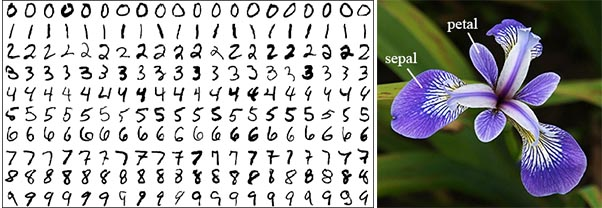

The following cell imports all packages needed in the coursework. You are not allowed to use any other packages than the ones listed below.
<a name='packages'></a>

In [1]:
# Importing packages
import numpy as np
import random
import os

import matplotlib.pyplot as plt

from scipy import optimize
from sklearn import datasets as skdataset
from sklearn.model_selection import train_test_split
from pathlib import Path

import os
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset

import imageio
from PIL import Image
import cv2

from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio
from IPython.display import Video

%matplotlib inline

The following code imports the drive module from Colab. This code will only run on Colab. If you're not using Colab, comment this code out, or don't run this cell.

In [2]:
from google.colab import drive
# Unmount any previously mounted drive if needed.
# Feel free to uncomment below line when you need to unmount Drive

# drive.flush_and_unmount()

The following cell sets the `drive_mount` variable. Set it to `True` if your Dataset folder is on drive. If you plan to use the Dataset folder locally, then set this to `False`

In [3]:
drive_mount = True

In [4]:
# Setting the seed
RAND_ST = 42
random.seed(RAND_ST)
#begin_test


#end_test




## Data Loading

The following cells are used to load IRIS and MNIST datasets.

In [5]:
def load_iris_dataset(num_classes=2):
    # Load the datadet from SkDataset
    iris = skdataset.load_iris()
    X = iris.data
    Y = iris.target
    # Reduce the number of classes
    idx = Y < num_classes
    X = X[idx]
    Y = Y[idx]
    return X, Y

In [6]:
def load_mnist_dataset(num_classes=2):
    # Load the datadet from SkDataset
    X, Y = skdataset.fetch_openml('mnist_784', version=1, return_X_y=True,as_frame=False)
    Y = Y.astype(np.int64)
    # Reduce the number of classes
    idx = Y < num_classes
    X = X[idx]
    Y = Y[idx]
    return X, Y

def load_mnist_dataset_onevsall(class_id=7):
    # Load the datadet from SkDataset
    X, Y = skdataset.fetch_openml('mnist_784', version=1, return_X_y=True,as_frame=False)
    Y = Y.astype(np.int64)
    # One versus all
    idx = Y == class_id
    Y[~idx] = 0
    Y[idx]  = 1
    return X, Y

## Functions for visualization

In [7]:
def plot_correlation(X1, X2):
    # Plot both variables
    plt.figure(figsize=(8, 6))
    plt.clf()
    plt.scatter(X1, X2, edgecolor='k')
    line = np.linspace(min(X1.min(), X2.min()), max(X1.max(), X2.max()), 20)
    plt.plot(line, line, 'r')
    plt.xlabel('Variable 1')
    plt.ylabel('Variable 2')
    plt.show()

In [8]:
def plot_eigenvecs(stacked_images, n_rows, n_columns, img_shape=None, channels=1):
    n_images, n_dims = stacked_images.shape
    plt.figure()
    for i in range(n_rows * n_columns):
        plt.subplot(n_rows, n_columns, i + 1)
        if channels == 1:
            # Normalize eigen vector to [0, 255] range
            eigenvector = stacked_images[i] - np.min(stacked_images[i])
            eigenvector /= np.max(eigenvector) + 1e-8
            eigenvector = (eigenvector * 255).astype(np.uint8)
            plt.imshow(np.reshape(eigenvector, [int(np.sqrt(n_dims)), int(np.sqrt(n_dims))]), cmap='gray')
        elif channels == 3:
            # Normalize eigen vector to [0, 255] range for each channel
            eigenvector = stacked_images[i].reshape(img_shape[0], img_shape[1], 3)
            eigenvector -= np.min(eigenvector)
            eigenvector /= np.max(eigenvector) + 1e-8
            eigenvector = (eigenvector * 255).astype(np.uint8)
            plt.imshow(eigenvector)
        plt.axis('off')
    plt.show()

def plot_images(stacked_images, n_rows, n_columns, titles, num_channels=1):
    n_images, n_dims = stacked_images.shape
    plt.figure()
    for i in range(n_rows * n_columns):
        plt.subplot(n_rows, n_columns, i + 1)

        if num_channels == 1:
            # Grayscale image
            plt.imshow(np.reshape(stacked_images[i], [int(np.sqrt(n_dims)), int(np.sqrt(n_dims))]), cmap='gray', vmin=0, vmax=1)
        elif num_channels == 3:
            # RGB image
            image = np.reshape(stacked_images[i], [int(np.sqrt(n_dims // 3)), int(np.sqrt(n_dims // 3)), 3])
            image = np.clip(image, 0, 1)  # Ensure pixel values are within [0, 1] range
            plt.imshow(image)
        else:
            raise ValueError("Unsupported number of channels. Use num_channels=1 for grayscale or num_channels=3 for RGB.")

        plt.axis('off')

        if len(titles) == n_rows * n_columns:
            plt.title(titles[i])

    plt.show()

def plot_images_with_text(images, titles, texts=None):
    N_cols = len(images)
    N_rows = len(images[0])

    fig, axs = plt.subplots(N_rows, N_cols, figsize=(20, 15))

    if titles is not None:
        for i, ax in enumerate(axs[0]):
            ax.set_title(titles[i])

    for i, img_col in enumerate(images):
        for j, img in enumerate(img_col):
            if len(img.shape) == 2:
                axs[j,i].imshow(img, interpolation='nearest', cmap='gray')
            else:
                axs[j,i].imshow(img, interpolation='nearest')
            axs[j,i].axis('off')
            if texts is not None:
                axs[j,i].text(0.5,-0.1, str(texts[j][i])[:4], size=10, ha="center", transform=axs[j,i].transAxes)
    plt.show()



In [9]:
def plot_images_horizontal(imgs):
    num_imgs = len(imgs)
    f = plt.figure(figsize=(40, 15))
    for i in range(num_imgs):
        f.add_subplot(1, num_imgs, i+1)
        plt.imshow(imgs[i])
    plt.show()

In [10]:
def true_positive(Y_test, y_pred):
    mask = (Y_test == 1)
    tp = (Y_test[mask] == y_pred[mask]).sum()
    return tp.item()

def true_negative(Y_test, y_pred):
    mask = (Y_test == 0) | (Y_test == -1)
    tn = (Y_test[mask] == y_pred[mask]).sum()
    return tn.item()

def false_negative(Y_test, y_pred):
    mask = (y_pred == 0) | (y_pred == -1)
    tn = (Y_test[mask] != y_pred[mask]).sum()
    return tn.item()

def false_positive(Y_test, y_pred):
    mask = (y_pred == 1)
    tn = (Y_test[mask] != y_pred[mask]).sum()
    return tn.item()

def plot_confusion_matrix(Y_test, y_pred):
    tp = true_positive(Y_test, y_pred)
    tn = true_negative(Y_test, y_pred)
    fp = false_positive(Y_test, y_pred)
    fn = false_negative(Y_test, y_pred)
    cf = np.array([[tn, fp], [fn, tp]])
    fig, ax = plt.subplots()
    ax.matshow(cf, cmap=plt.cm.Blues)
    for i in range(2):
        for j in range(2):
            c = cf[i,j]
            ax.text(j, i, str(c), va='center', ha='center')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.show()

## Data Loading

In the following cells, the dataset is created with proper splits between training and test set.

_IRIS_ dataset

In [ ]:
X, Y = load_iris_dataset(num_classes=3)
X_iris, X_iris_test, Y_iris, Y_iris_test = train_test_split(X, Y, test_size=0.1, random_state=RAND_ST) # 90% training and 10% test

_MNIST_ **dataset**

In [ ]:
X, Y = load_mnist_dataset(num_classes=10)
X = X / 255.0
X_mnist, X_mnist_test, Y_mnist, Y_mnist_test = train_test_split(X, Y, test_size=0.1, random_state=RAND_ST) # 90% training and 10% test

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


**Code for handling the Dataset zip file**

The following cell mounts your drive if `drive_mount` is `True`

In [11]:
if drive_mount:
  drive.mount('/content/drive')

Mounted at /content/drive


Set `dataset_path` to Drive or local directory. Also load the CelebA dataset for PCA

In [12]:
if drive_mount:
  dataset_path = '/content/drive/MyDrive/cw_datasets/'
  assert(os.path.exists(dataset_path))
  # Set this path to your appropriate drive path
else:
  dataset_path = "./cw_datasets"
  # In this case, the datasets path is assumed to be in the same directory as this notebook

  if not os.path.exists("./cw_datasets"):
    !wget https://geometry.cs.ucl.ac.uk/mlvc/cw_datasets.zip
    !unzip -q -o cw_datasets.zip

def load_face_images_array(dataset_path="./cw_datasets/",test_fraction=0.05):
  images_path = os.path.join(dataset_path,"face_pca/")
  flattened_images_list = []
  images_paths = [os.path.join(images_path,p) for p in os.listdir(images_path) if p.endswith(".jpg")]
  for image_file in images_paths:
    image_np = np.array(Image.open(image_file))/255.0
    image_np_flattened = np.reshape(image_np,(1,-1))
    flattened_images_list.append(image_np_flattened)
  flattened_images = np.concatenate(flattened_images_list,0)
  split_at = int(len(flattened_images)*test_fraction)
  X_CelebA_test = flattened_images[:split_at]
  X_CelebA = flattened_images[split_at:]
  return X_CelebA, X_CelebA_test

X_CelebA,X_CelebA_test = load_face_images_array(dataset_path)
print(X_CelebA.shape,X_CelebA_test.shape)

(95, 3072) (5, 3072)


## 1. Linear Fitting (10 points)
<a name='question1'></a>

[a)](#question1a) Implement the normal equation solver function **nsolve**, which takes as input the matrix **X** and the target vector **y** and returns the optimized weights **w**. Test your code with your own mockup/randomly created data. (**5 points**)

[b)](#question1b) Implement **line_fit(X,y)** which should fit a linear function to the input data. Test your implementation on the following task: predict with linear fitting the _petal length (cm)_ of the Iris dataset using the three remaining variables as inputs (_sepal length (cm)_, _sepal width (cm)_ and _petal width (cm)_). Report the L2 loss on the validation set and plot a graph showing the correlation between y and your prediction on the test set. (**2 points**)

[c)](#question1c) Implement **poly_fit(X,y)** which should fit a 2nd degree polynomial to the input data. Test your implementation on the following task: predict with the polynomial the petal width (cm) of the _IRIS_ dataset using the three remaining variables as inputs (sepal length (cm), sepal width (cm), petal length (cm)). The 2nd degree polynomial should consider all possible pairwise terms, i.e. $w_1x^2 + w_2xy+ w_3y^2 + w_4x+ w_5y+ w_6$ in the case of two input variables $x$ and $y$. Report the L2 loss on the validation set and plot a graph showing the correlation between $y$ and your prediction on the test set. (**3 points**)

**Question 1a**
<a name='question1a'></a>

Implement the nsolve function

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def nsolve(X,y):
    """
    Write your implementation of nsolve here.

    Arguments:
    X : Data matrix
    y : Labels

    Returns:
    w : Weights
    """

    #begin_solution

    w = (np.linalg.inv((X.transpose() @ X)) @ X.transpose()) @ y

    #end_solution


    return w

Testing your code on mockup/randomly created data.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
"""
After implementing nsolve, test it below on some mock data using np.random
"""

#begin_solution

noise_margin = 2
x_test = np.linspace(-5, 5, 20).reshape(-1, 1)
w_test = np.random.rand(2,1)
X_test = np.column_stack([np.ones([x_test.shape[0], 1]), x_test])
# add some noise
y_test = w_test[0] + w_test[1] * x_test + noise_margin * np.random.rand(len(x_test), 1)
w_nsolve = nsolve(X_test, y_test)
print("w_test : [%f, %f]" % (w_test[0], w_test[1]))
print("w_nsolve : [%f, %f]" % (w_nsolve[0], w_nsolve[1]))

#end_solution


w_test : [0.098377, 0.536945]
w_nsolve : [1.183062, 0.484815]


**Question 1b**
<a name='question1b'></a>

Implement the line_fit function and test

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def line_fit(X,y):
    """
    Write your implementation of line_fit here.

    Arguments:
    X : Data matrix
    y : Labels

    Returns:
    w : Weights
    l2_error : L2 Prediction error using learned w
    """

    #begin_solution
    # Add bias by stack ones on the left
    X = np.column_stack([np.ones([X.shape[0], 1]), X])
    w = nsolve(X, y)
    l2_error = y - X @ w
    l2_error = l2_error.T @ l2_error
    l2_error /= len(y)
    #end_solution


    return w, l2_error

Testing your code on _IRIS_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
"""
After implementing line_fit, test it below on IRIS Train set.
Print the L2 error on the Training set.
"""

#begin_solution
w, l2_error = line_fit(X_iris[:, [0,1,3]], X_iris[:,2])
print("L2 error on IRIS Train Set : %f" % (l2_error))
#end_solution


L2 error on IRIS Train Set : 0.092543


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
"""
After implementing line_fit, test it below on IRIS Test set.
Print the L2 error with respect to Test set.
"""

#begin_solution
l2_error = X_iris_test[:,2] - np.column_stack([np.ones([X_iris_test.shape[0], 1]), X_iris_test[:, [0,1,3]]]) @ w
l2_error = l2_error.T @ l2_error
l2_error /= len(X_iris_test[:,2])
print("L2 error on IRIS Test Set : %f" % (l2_error))
#end_solution


L2 error on IRIS Test Set : 0.162488


Showing the correlation between X and y.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

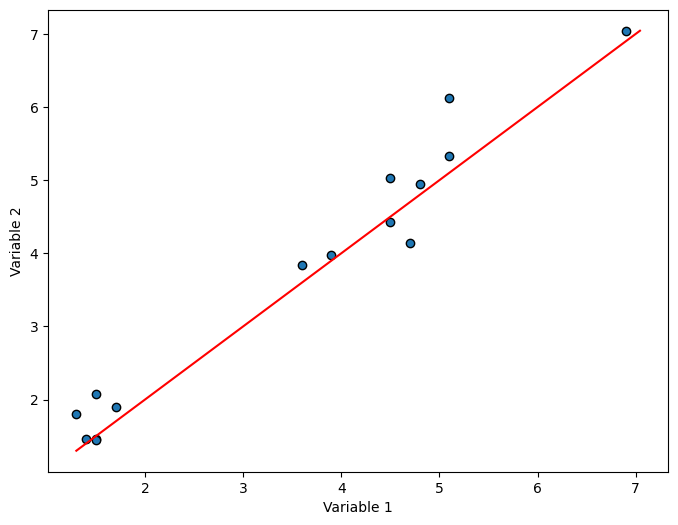

In [ ]:
"""
Below, plot and display the correlation between true y and predicted values.
"""
#begin_solution
predictied_y = (np.column_stack([np.ones([X_iris_test.shape[0], 1]), X_iris_test[:, [0,1,3]]]) @ w).reshape(1, -1)
true_y = X_iris_test[:,2].reshape(1, -1)
plot_correlation(true_y, predictied_y)
#end_solution


Do not write anything in the cell below, it is for TAs

In [ ]:
#begin_test


#end_test



**Question 1c**
<a name='question1c'></a>

Implement the poly_fit function and test

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def poly_fit(X,y):
    """
    Write your implementation of poly_fit here.

    Arguments:
    X : Data matrix
    y : Labels

    Returns:
    w : Weights
    l2_error : L2 prediction error using learned w
    """

    #begin_solution
    n_data, n_feature = X.shape
    new_data = np.ones((n_data, 1))
    # construct polynomial, by stacking columns of x, x^2, xy for loop x and y, y^2 for loop y.
    for i in range(n_feature):
        new_data = np.hstack((new_data, X[:, i].reshape(-1, 1)))
        for j in range(i, n_feature):
            new_data = np.hstack((new_data, (X[:, i] * X[:, j]).reshape(-1, 1)))
    X = new_data
    w = nsolve(X,y)
    l2_error = y - X @ w
    l2_error = l2_error.T @ l2_error
    l2_error /= len(y)
    #end_solution


    return w, l2_error

Testing your code on _IRIS_.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
"""
After implementing poly_fit, test it below on IRIS Training set.
Print L2 error with respect to training set.
"""

#begin_solution
w, l2_error = poly_fit(X_iris[:,0:3], X_iris[:,3])
print("L2 error on IRIS Train Set : %f" % (l2_error))
#end_solution


L2 error on IRIS Train Set : 0.030979


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
"""
After implementing poly_fit, test it below on IRIS Test set.
Print L2 error with respect to test set.
"""

#begin_solution
X = X_iris_test[:,0:3]
Y = X_iris_test[:,3]
n_data, n_feature = X.shape
new_data = np.ones((n_data, 1))
# construct polynomial data
for i in range(n_feature):
    new_data = np.hstack((new_data, X[:, i].reshape(-1, 1)))
    for j in range(i, n_feature):
        new_data = np.hstack((new_data, (X[:, i] * X[:, j]).reshape(-1, 1)))
l2_error = Y - new_data @ w
l2_error = l2_error.T @ l2_error
l2_error /= len(Y)
print("L2 error on IRIS Test Set : %f" % (l2_error))
#end_solution


L2 error on IRIS Test Set : 0.049557


Showing the correlation between X and y.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

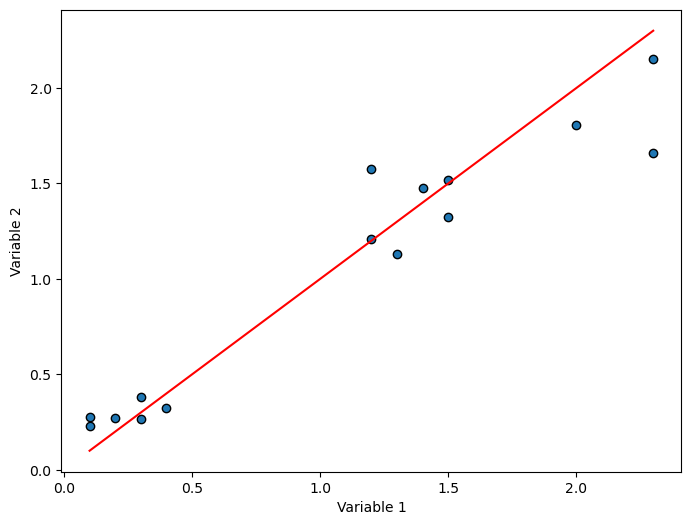

In [ ]:
"""
Below, plot and display the correlation between true y and predicted values
"""

#begin_solution
predictied_y = (new_data @ w).reshape(1, -1)
true_y = Y.reshape(1, -1)
plot_correlation(true_y, predictied_y)
#end_solution


Do not write anything the cell below, it is for TAs

In [ ]:
#begin_test


#end_test



## 2. PCA (12 points)
<a name='question2'></a>

[a)](#question2a) Implement a function pca(X, ndims) that performs PCA over the input data X and returns both the mean vector  ̄X and the ndims top components. The top components are the eigen vectors linked to the top eigen values computed from the covariance matrix. Try your function on the _MNIST_ dataset (which is composed of 10 digit classes) and on the _CELEBA_ dataset (which contains face RGB images). Display the top 10 components fitted on the train dataset as images.(**2 points** + **2 points** + **2 points**)

[b)](#question2b) Next, check that you can reconstruct perfectly an input image (digit or face) from the test set using all components, by implementing pca_projection(X, mean_vec, eig_vecs) and pca_reconstruction(weights, mean_vec, eig_vecs). (**2 points** + **2 points** + **2 points** on hidden dataset)

**Question 2a**
<a name='question2a'></a>

Implement PCA and plot Eigenvectors

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def pca(X, ndims, num_image_channels=1):
    """
    Compute PCA on a batch of flattened grayscale or RGB images with dynamic dimensions.

    Arguments:
    X : Data matrix where each row is a flattened image
    ndims : Number of reduced dimensions

    Returns:
    mean_vec : Data mean
    top_eig_vecs : Selected eigen vectors, a matrix where each column corresponds
                    to an eigen vector
    """

    #begin_solution
    # Calculate Data Mean
    mean_vec = np.mean(X, axis=0)
    m, n = X.shape
    X = X - np.tile(mean_vec, (m, 1))
    # Calculate covariance
    covX = np.cov(X.T)
    # Calculate Eigen Values and Eigen vectors
    eigen_value, eigen_vec = np.linalg.eigh(covX)
    index = np.argsort(eigen_value)[::-1]
    top_eig_vecs = eigen_vec[:, index[:ndims]]
    #end_solution


    return mean_vec, top_eig_vecs


Testing your code on _MNIST_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

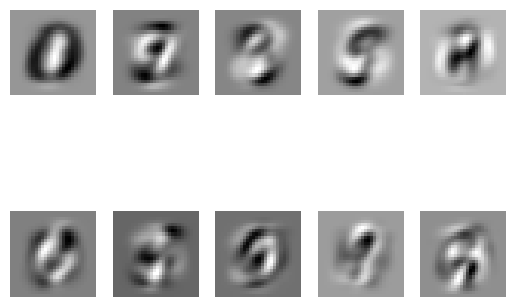

In [ ]:
"""
Below, test your PCA on  MNIST dataset.
Plot and display the selected eigen vectors returned by PCA.

Use the plot_eigenvecs function provided above.
Read that function and pass arguments as needed.
"""

#begin_solution
# X_mnist.shape = [36000, 784]
mean_vec, top_eig_vecs = pca(X_mnist, ndims=10)
plot_eigenvecs(top_eig_vecs.T, n_rows=2, n_columns=5, channels=1)
#end_solution


Testing your code on _CelebA_

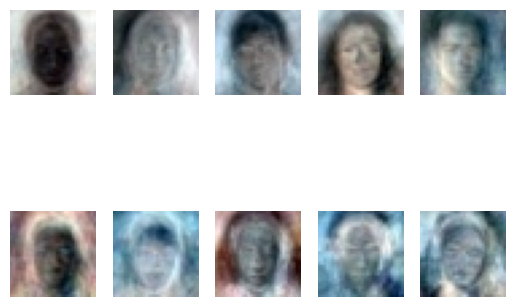

In [ ]:
"""
Below, test your PCA on  CelebA dataset.
Plot and display the selected eigen vectors returned by PCA.

Use the plot_eigenvecs function provided above.
Read that function and pass arguments as needed.
"""

#begin_solution
# X_CelebA.shape = [95, 32*32*3]
mean_vec, top_eig_vecs = pca(X_CelebA, ndims=10, num_image_channels=3)
plot_eigenvecs(top_eig_vecs.T, n_rows=2, n_columns=5, img_shape=(32,32), channels=3)
#end_solution


Do not write anything in the cell below, it is for the TAs

In [ ]:
#begin_test


#end_test



**Question 2b**

Now, we can evaluate if the code is working properly by projecting the first image of the test set on the eigen vectors.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>


In [ ]:
def pca_projection(X, mean_vec, eig_vecs):
    """
    Write your implenetation of PCA projection here.

    Arguments:
    X : Data matrix
    mean_vec : Data mean
    eig_vecs : A numpy array where each column corresponds to an eigen vector

    Returns:
    weights : Weights corresponding to the eigen vectors
    """
    #begin_solution
    X = X - mean_vec
    X = X.reshape(1, -1)
    weight = X @ eig_vecs
    #end_solution


    return weight

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def pca_reconstruction(weights, mean_vec, eig_vecs):
    """
    Write your implementation of PCA reconstruction here.

    Arguments:
    weights : Weights obtained from pca_projection
    mean_vec : Data mean
    eig_vecs : A numpy array where each column corresponds to an eigen vector
    """

    #begin_solution
    reconstruction = np.dot(weights, eig_vecs.T) + mean_vec
    #end_solution


    return reconstruction

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

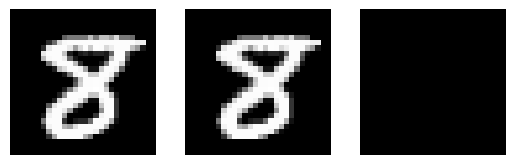

In [ ]:
"""
Below,
1. Perform  PCA on MNIST training set, without reducing dimensions.
2. Project the first image of Test set to the eigen vectors using pca_projection.
3. Reconstruct that image using pca_reconstruction.
4. Display side-by-side, the Test image, its projection and the
   pixelwise difference between the two. Use the plotting functions provided.
"""

#begin_solution
mean_vec, top_eig_vecs = pca(X_mnist, ndims=X_mnist.shape[1])
img = X_mnist_test[0].reshape(1, -1)
weights = pca_projection(img, mean_vec, top_eig_vecs)
reconstruction = pca_reconstruction(weights, mean_vec, top_eig_vecs).astype(float)
images = np.array([img[0], reconstruction[0], np.abs(img[0] - reconstruction[0])])
plot_images(images, 1, 3, 'PCA on MNIST', 1)
# plot_images(reconstruction, )

#end_solution


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

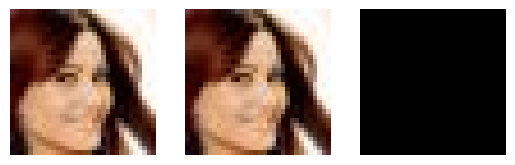

In [ ]:
"""
Below,
1. Perform  PCA on CelebA training set, without reducing dimensions.
2. Project the first image of Test set to the eigen vectors using pca_projection.
3. Reconstruct that image using pca_reconstruction.
4. Display side-by-side, the Test image, its projection and the
   pixelwise difference between the two. Use the plotting functions provided.
"""

#begin_solution
mean_vec, top_eig_vecs = pca(X_CelebA, ndims=X_CelebA.shape[1])
img = X_CelebA_test[0]
weights = pca_projection(img, mean_vec, top_eig_vecs)
reconstruction = pca_reconstruction(weights, mean_vec, top_eig_vecs).astype('float')
images = np.vstack((img, reconstruction, np.abs(img - reconstruction)))
plot_images(images, 1, 3, 'PCA on CelebA', 3)
#end_solution


#### If your PCA reconstruction for faces is imperfect, discuss why that is the case. Edit the cell below with "Your reply" ####

_Your reply here:_  
If use np.linalg.eig(), the reconstruction result may not be perfect. It may be caused by computing inaccuracy.

Don't write anything in the block below, its for TAs

In [ ]:
#begin_test


#end_test



## 3. Linear Classification (18 points)
<a name='question3'></a>

[a)](#question3a) Implement the normal equation-based binary linear classifier lclass(examplesA, examplesB, testExamples) where the first two arguments are the set of samples from class A and class B respectively and the third is the test. The function should return a vector of 0s and 1s, 0 if test is in A and 1 otherwise. It should, for simplicity, both train and test in one function call. (**3 points**)
Test this on all the samples in _IRIS_, Setosa vs non-Setosa, and plot the confusion matrix. (**4 points** on hidden dataset)

[b)](#question3b) Extend the implementation in 3a to do multi-class classification. Implement lclass_prob(examplesA, examplesB, testExamples) and lmclass(examples, class, testExamples) that together perform multi-class classification of the examples examples according to the vector of labels class of the same size and test it with testExamples by returning a matrix, where each row expresses the probability of a sample in testExamples to belong to each class. Give the accuracy of your model. (**5 points** + **6 points** on hidden dataset)

Present findings applying multi-class classification on _IRIS_ dataset with 3 classes.

**Question 3a**
<a name='question3a'></a>

Implement Linear, binary classifier and test

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def lclass(examplesA, examplesB, testExample):
    """
    Write your implementation of normal equation based linear classifier here.

    Arguments:
    examplesA : Matrix of samples from class A
    examplesB : Matrix of samples from class B
    testExample : Matrix of test samples to predict on

    Returns:
    preds : Predicted 0/1 labels on testExample
    """

    #begin_solution
    # w = (X.T @ X)^(-1) @ X.T @ y
    # merge data from different classes and add bias column
    X = np.vstack((examplesA, examplesB))
    X = np.hstack((np.ones(examplesA.shape[0] + examplesB.shape[0]).reshape(-1,1), X))
    # merge labels
    y = np.vstack((np.zeros((examplesA.shape[0], 1)), np.ones((examplesB.shape[0], 1))))
    w = np.linalg.inv(X.T @ X) @ X.T @ y
    testExample = np.hstack((np.ones(testExample.shape[0]).reshape(-1,1), testExample))
    preds = testExample @ w
    # decide which class do predicted values belong to
    preds = np.select((preds < 0.5, preds >= 0.5), (0, 1)).squeeze().astype(int)
    #end_solution


    return preds

_IRIS_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
"""
After implementing lclass, test it below on the IRIS dataset.
"""

#begin_solution
A_idx = np.where(Y_iris == 0)
B_idx = np.where(Y_iris != 0)
A_test_idx = np.where(Y_iris_test == 0)
B_test_idx = np.where(Y_iris_test != 0)
test_idx = np.hstack((A_test_idx, B_test_idx)).squeeze()
examplesA = X_iris[A_idx]
examplesB = X_iris[B_idx]
testExample = X_iris_test[test_idx]
preds = lclass(examplesA, examplesB, testExample)
print(f'Prediction on Y_iris_test: {preds}')
#end_solution


Prediction on Y_iris_test: [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
Y_iris_test[test_idx]

array([0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 2, 1, 1, 2])

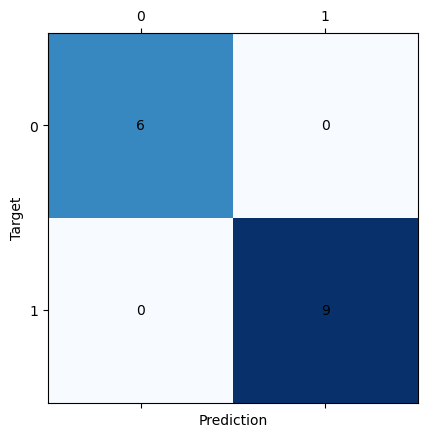

In [ ]:
"""
Below, plot and display the confusion matrix of your prediction with respect to
true values. Use provided functions for plotting.
"""

#begin_solution
Y_label = Y_iris_test[test_idx]
Y_label[Y_label != 0] = 1
plot_confusion_matrix(Y_label, preds)
#end_solution


Do not write anything in the cell below, it is for the TAs

In [ ]:
#begin_test


#end_test



**Question 3b**
<a name='question3b'></a>

Implement Linear, multi-class classifier and test

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def softmax(preds):
  """
  Write your implementation of the softmax activation here.

  Arguments:
  preds : The output predicted classes from your classifier

  Returns:
  activation : The outputs after applying softmax activation
  """

  #begin_solution
  activation = np.exp(preds)
  activation = activation / np.sum(activation)
  #end_solution


  return activation

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def lclass_prob(examplesA, examplesB, testExample):
    """
    Write your implementation of lclass_prob here.

    Arguments:
    examplesA : Matrix of samples from class A
    examplesB : Matrix of samples from class B
    testExample : Matrix of test samples to predict on

    Returns:
    preds : Predicted probabilities of samples in testExample belonging to a class.
    """

    #begin_solution
    # Combination of both categories
    X = np.vstack((examplesA, examplesB))
    # Add ones on the first column, to set bias
    X = np.hstack((np.ones(examplesA.shape[0] + examplesB.shape[0]).reshape(-1,1), X))
    y = np.vstack((np.zeros((examplesA.shape[0], 1)), np.ones((examplesB.shape[0], 1))))
    testExample = np.hstack((np.ones(testExample.shape[0]).reshape(-1,1), testExample))
    # Normal Equation
    w = np.linalg.inv(X.T @ X) @ X.T @ y
    preds = testExample @ w
    # Softmax or sigmoid
    # preds = 1-softmax(preds)
    preds = 1-(1/(1+np.exp(-preds)))
    preds = preds.squeeze()
    #end_solution


    return preds

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def lmclass(examples, labels, testExample):
    """
    Write your implementation of multiclass classifier lmclass here.
    Use your lclass_prob implementation here to solve this.

    Arguments:
    examples : The training data matrix
    labels : The training labels
    testExample : The testing data matrix

    Returns:
    preds_prob : For each sample in testExample, their predicted probabilities
                 of belonging to each class
    """

    #begin_solution
    class_num = len(np.unique(labels))
    preds_prob = np.zeros((testExample.shape[0], class_num))
    for i in range(class_num):
        # separate data and choose the one to classify, and set other data as 2nd category.
        # input both data to lclass_prob
        selected_data = examples[np.where(labels == i)]
        other_data = examples[np.where(labels != i)]
        prob = lclass_prob(selected_data, other_data, testExample)
        preds_prob[:, i] = prob
    #end_solution


    return preds_prob

Print the accuracy of the prediction below

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
#begin_solution
preds_prob = lmclass(X_iris, Y_iris, X_iris_test)
pred_class = np.argsort(-preds_prob)[:, 0].squeeze()
accuracy = np.zeros(len(np.unique(Y_iris)))
for i in np.unique(Y_iris):
    mask = (Y_iris_test == i)
    accuracy[i] = np.sum(pred_class[mask] == Y_iris_test[mask]) / len(Y_iris_test[mask])
    print("The accuracy for Class %d: %.2f%%" % (i, accuracy[i] * 100))
#end_solution


The accuracy for Class 0: 100.00%
The accuracy for Class 1: 66.67%
The accuracy for Class 2: 100.00%


Do not write anything in the cell below, it is for the TAs

In [ ]:
#begin_test


#end_test



## 4. Denoising (30 points)
<a name='question4'></a>

[a)](#question4a) Implement `denoiseGauss(image)` to denoise the image `noisy_image.png` under `cw_datasets/Filtering/` using a
5×5 Gaussian filter. (**5 points**)

[b)](#question4b) Implement a convolutional neural network in Pytorch to denoise an image. We provide you pairs of noisy and
noise-free image patches of size 128×128 for training and testing, under `cw_datasets/Denoising/`. You may use all the infrastructure of `Pytorch`. The network should have sufficient depth and complexity to be able to converge well.  Please use ReLU non-linearities after each layer (**20 points**).

[c)](#question4c) Given the comparison between the Gaussian-kernel denoising and the neural network denoising
methods, discuss which method performs better and why. You should write no more than 5 sentences. (**5 points**)


**Question 4a**
<a name='question4a'></a>

Implement the below functions to denoise the image

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [13]:
def gkern(l=5, sig=1.):

    #begin_solution
    # l needs to be odd
    axis_range = np.linspace(-l // 2, l // 2, l)
    x, y = np.meshgrid(axis_range, axis_range)
    # Construct a Gaussian kernel
    out_kernel = np.exp(-(x**2 + y**2)/(2 * sig**2))
    # Diveded by sum to normalize the kernel
    out_kernel /= np.sum(out_kernel)
    #end_solution


    return out_kernel

def denoise_gauss(image):

    #begin_solution
    # If image is RGB, then implement kernel on all channels
    C = 3 if len(image.shape) == 3 else 1
    kernel = gkern()
    if C == 3:
      H, W = image[...,0].shape
      denoised_image = np.zeros_like(image)
      for channel in range(3):
          # To make the size of image unchanged, we need to pad the image
          img = np.pad(image[:, :, channel], ((2, 2),(2, 2)), 'edge')
          for i in range(H):
              for j in range(W):
                  neighbors = img[i:i+5, j:j+5]
                  denoised_image[i][j][channel] = np.sum(kernel * neighbors)
    else:
      H, W = image.shape
      denoised_image = np.zeros_like(image)
      img = np.pad(image, ((2, 2),(2, 2)), 'edge')
      for i in range(H):
          for j in range(W):
              neighbors = img[i:i+5, j:j+5]
              denoised_image[i][j] = np.sum(kernel * neighbors)
    #end_solution


    return denoised_image

Load input image from file

In [14]:
if drive_mount:
  dataset_path = "/content/drive/MyDrive/cw_datasets/"
else:
  dataset_path = "./cw_datasets/"

noisy_image_filename = os.path.join(dataset_path,"Filtering/noisy_image.png")

Filter the input image

In [ ]:
noisy_image = np.asarray(Image.open(noisy_image_filename).convert('RGB'))
denoised_image = denoise_gauss(noisy_image)
plot_images_horizontal([noisy_image, denoised_image])

Output hidden; open in https://colab.research.google.com to view.

**Question 4b**
<a name='question4b'></a>

Implement a neural denoiser using Pytorch

Implement dataset class below. Note that the images output by the `DenoisingDB` dataset should be of size 128 x 128. Crop the original images at the top left corner to get the aforementioned size.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [15]:
class DenoisingDB(Dataset):

    def __init__(self, input_imgs_path, cleaned_imgs_path):
        super().__init__()

        #begin_solution
        self.input_imgs = []
        self.cleaned_imgs = []
        # In Colab, listdir() may list files in a wrong order, need to sort
        tmp = os.listdir(input_imgs_path)
        tmp.sort()
        for file in tmp:
            img = Image.open(input_imgs_path + file)
            # Standardize the size of images
            H = img.size[0] // 128
            W = img.size[1] // 128
            self.input_imgs.append(np.array(img.crop((0, 0, 128, 128))).astype(np.float32))
            # for i in range(H):
            #     for j in range(W):
            #         # The box that we want to crop the image
            #         box = (128 * i, 128 * j, 128 * (i + 1), 128 * (j + 1))
            #         self.input_imgs.append(np.array(img.crop(box)).astype(np.float32))
        for file in tmp:
            img = Image.open(cleaned_imgs_path + file)
            H = img.size[0] // 128
            W = img.size[1] // 128
            self.cleaned_imgs.append(np.array(img.crop((0, 0, 128, 128))).astype(np.float32))
            # for i in range(H):
            #     for j in range(W):
            #         box = (128 * i, 128 * j, 128 * (i + 1), 128 * (j + 1))
            #         self.cleaned_imgs.append(np.array(img.crop(box)).astype(np.float32))
        self.input_imgs = torch.Tensor(np.array(self.input_imgs)[:, np.newaxis, :, :])
        self.cleaned_imgs = torch.Tensor(np.array(self.cleaned_imgs)[:, np.newaxis, :, :])
        #end_solution


    def __len__(self):
        #begin_solution
        length = len(self.input_imgs)
        #end_solution

        return length

    def __getitem__(self, idx):

        #begin_solution
        input_img = self.input_imgs[idx]
        cleaned_img = self.cleaned_imgs[idx]
        #end_solution


        return (input_img, cleaned_img)

Implement the Denoising network:

Note that the network need to be sufficiently complex for performing the denoising task successfully. Feel free to experiment with different layers, blocks and operations.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [16]:
class DenoisingCNN(nn.Module):
    def __init__(self):
        super(DenoisingCNN, self).__init__()

        #begin_solution
        self.kernel_size = 3
        self.filters = 128
        self.conv_num = 15
        self.layers = []
        self.conv2d_1 = nn.Conv2d(in_channels=1,
                      out_channels=self.filters,
                      kernel_size=self.kernel_size,
                      stride=1,
                      padding=1)
        self.conv2d_2 = nn.Conv2d(in_channels=self.filters,
                      out_channels=1,
                      kernel_size=self.kernel_size,
                      stride=1,
                      padding=1)

        self.layers.append(self.conv2d_1)
        self.layers.append(nn.ReLU())

        for _ in range(self.conv_num):
          self.layers.append(nn.Conv2d(in_channels=self.filters,
                        out_channels=self.filters,
                        kernel_size=self.kernel_size,
                        stride=1,
                        padding=1))
          self.layers.append(nn.BatchNorm2d(self.filters))
          self.layers.append(nn.ReLU())

        self.layers.append(self.conv2d_2)

        self.dncnn = nn.Sequential(*self.layers)
        #end_solution


    def forward(self, x):

        #begin_solution
        input = x.clone()
        x = self.dncnn(x)
        # Get noise v, return x = y - v
        x = input - x
        #end_solution


        return x

# Create an instance of the network
model = DenoisingCNN()


Implement the reconstruction loss

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [17]:
def loss_function(prediction, target):
    """
    Calculate the Mean Squared Error (MSE) loss between the prediction and the target.

    Arguments:
    prediction : torch.Tensor
        The predicted image.
    target : torch.Tensor
        The target image for reconstruction.

    Returns:
    loss : torch.Tensor
        The computed loss.
    """

    #begin_solution
    # Pytorch method
    loss = torch.mean((prediction - target) ** 2)
    #end_solution


    return loss


Paths to input data

In [18]:
if drive_mount:
  dataset_path = "/content/drive/MyDrive/cw_datasets/"
else:
  dataset_path = "./cw_datasets/"

input_imgs_path = os.path.join(dataset_path,"Denoising/input_noisy_images/")
cleaned_imgs_path = os.path.join(dataset_path,"Denoising/target_clean_images/")

dataset = DenoisingDB(input_imgs_path, cleaned_imgs_path)

Write the training loop

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [19]:
#begin_solution
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Construct Dataloader to implement mini-batch training
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 1000

for epoch in range(epochs):
    total_loss = 0

    for batch in data_loader:
        input_imgs, cleaned_imgs = batch
        input_imgs = input_imgs.to(device)
        cleaned_imgs = cleaned_imgs.to(device)

        output_imgs = model(input_imgs)
        loss = loss_function(output_imgs, cleaned_imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() / len(data_loader)

    print('Epoch', epoch, 'Loss', total_loss)
#end_solution

Epoch 0 Loss 1292.7988037109376
Epoch 1 Loss 1080.8427978515624
Epoch 2 Loss 910.1665405273437
Epoch 3 Loss 713.3800537109375
Epoch 4 Loss 565.2231567382812
Epoch 5 Loss 453.05546875000005
Epoch 6 Loss 357.00873413085935
Epoch 7 Loss 327.86531372070317
Epoch 8 Loss 261.0313323974609
Epoch 9 Loss 224.00673522949216
Epoch 10 Loss 201.45898132324217
Epoch 11 Loss 183.06143493652343
Epoch 12 Loss 172.97173767089845
Epoch 13 Loss 176.13285217285156
Epoch 14 Loss 170.8997528076172
Epoch 15 Loss 170.34271545410155
Epoch 16 Loss 164.87448120117188
Epoch 17 Loss 155.11070861816404
Epoch 18 Loss 151.45107116699216
Epoch 19 Loss 153.40633850097657
Epoch 20 Loss 141.72039184570315
Epoch 21 Loss 141.69373779296876
Epoch 22 Loss 134.6479232788086
Epoch 23 Loss 138.84682006835936
Epoch 24 Loss 131.96689147949218
Epoch 25 Loss 128.167041015625
Epoch 26 Loss 126.91657867431641
Epoch 27 Loss 127.58928070068359
Epoch 28 Loss 124.29363403320312
Epoch 29 Loss 121.45623779296876
Epoch 30 Loss 120.7899337768

Save the model (needed for marking)

In [20]:
if not os.path.exists("models/"):
  os.makedirs("./models/")
torch.save({"denoiser":model}, "models/denoiser.pth")

Load trained model

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state_dict = torch.load("models/denoiser.pth")
denoiser = state_dict["denoiser"].to(device)

Plot 5 input images and their relative denoised images side by side. Populate the 3 lists of input, gt and output with 5 images each.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

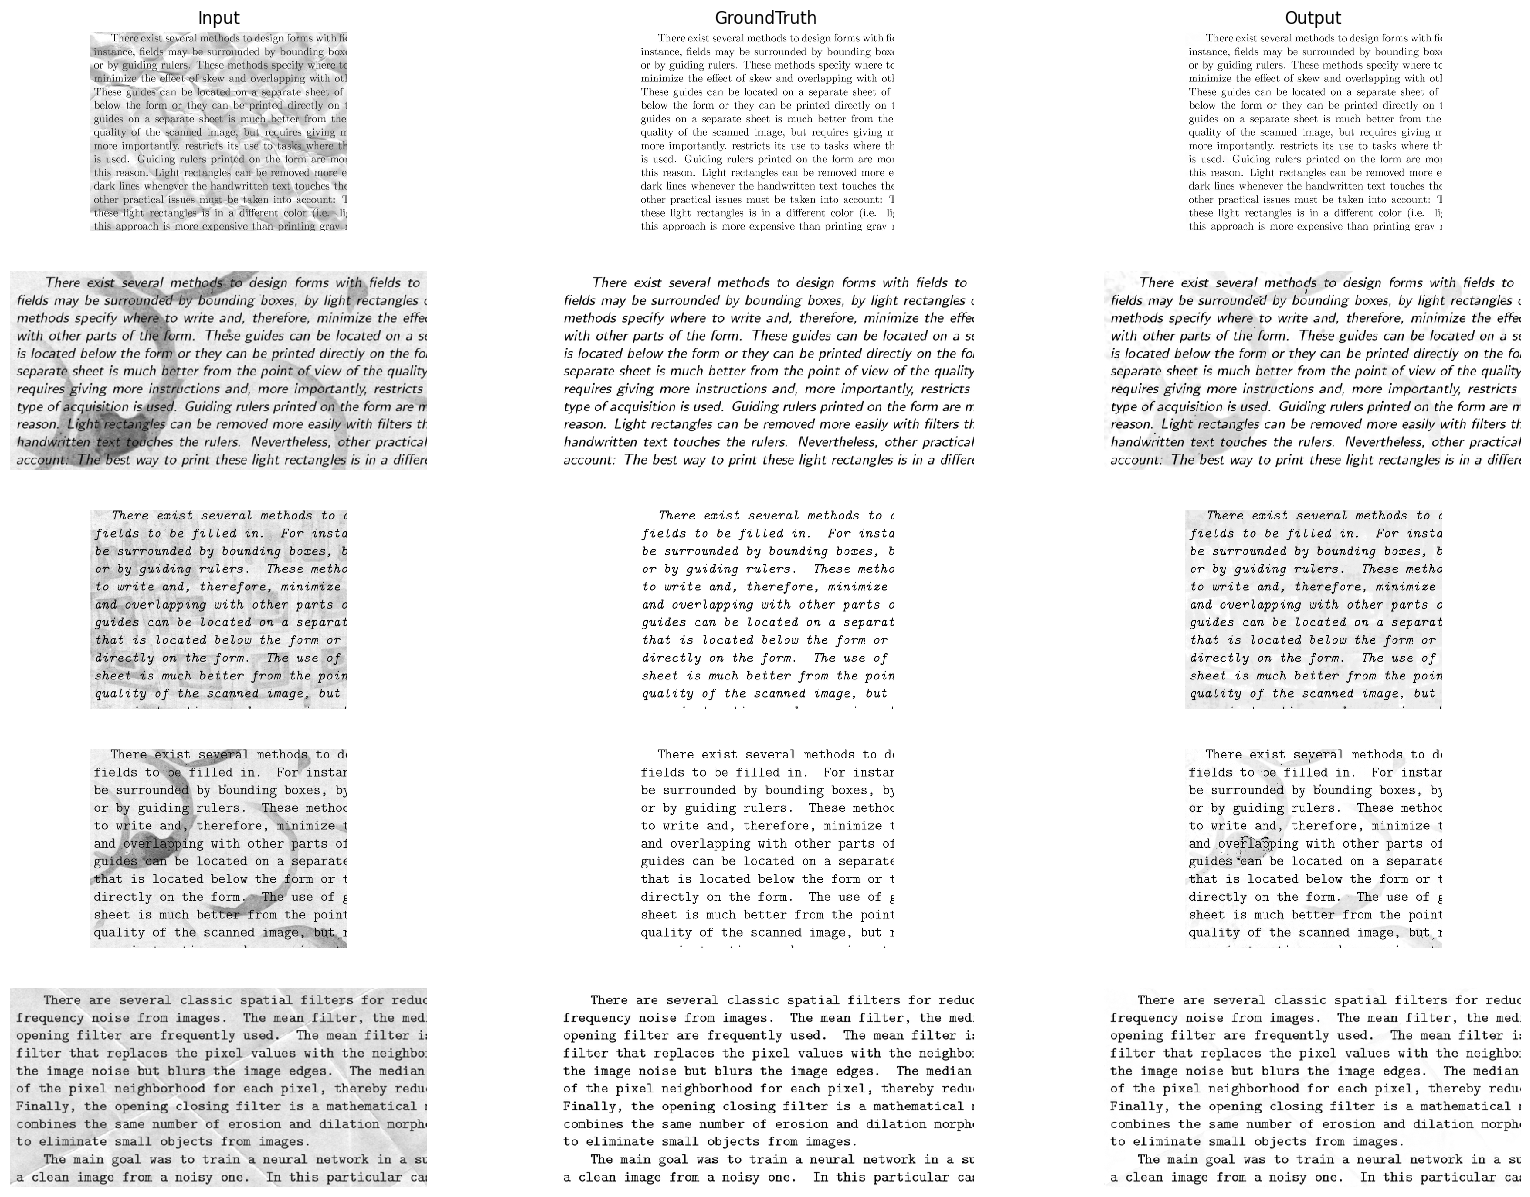

In [22]:
input_imgs, gt_imgs, output_imgs = [], [], []

#begin_solution
file_list = os.listdir(input_imgs_path)
# Randomly pick 5 images
random_idx = np.random.randint(len(file_list), size=5)
output_data = []
for idx in random_idx:
    input_img = Image.open(input_imgs_path + file_list[idx])
    cleaned_img = Image.open(cleaned_imgs_path + file_list[idx])
    input_data = np.array(input_img).astype(np.float32)
    input_imgs.append(input_data)
    gt_imgs.append(np.array(cleaned_img))
    # Expand the size of image to [batch_size, channel, H, W]
    input_data = input_data[np.newaxis, np.newaxis, :, :]
    input_data = torch.Tensor(input_data).to(device)
    output = denoiser(input_data).cpu().detach().numpy().squeeze().squeeze()
    output[output > 255] = 255
    output[output < 0] = 0
    output_imgs.append(output.astype(int))

#end_solution


titles = ['Input', 'GroundTruth', 'Output']
plot_images_with_text([input_imgs, gt_imgs, output_imgs],titles,texts=None)


Compute images for both the AE and Gaussian Kernels algorithm from `images`.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [23]:
dataset = DenoisingDB(input_imgs_path,cleaned_imgs_path)

images = [dataset[i][0].to(device) for i in range(5)]
targets = [dataset[i][1].to(device) for i in range(5)]
images_ae = []
images_gauss = []

#begin_solution
for i in range(5):
  output = denoiser(images[i][np.newaxis,...]).cpu().detach().numpy().squeeze()
  # Output from model may exceed the range of (0, 255), crop the value
  output[output > 255] = 255
  output[output < 0] = 0
  images_ae.append(output.astype(int))
images_gauss = [denoise_gauss(images[i].squeeze().cpu().detach().numpy()).astype(int) for i in range(5)]

images = [images[i].type(torch.IntTensor) for i in range(5)]
targets = [targets[i].type(torch.IntTensor) for i in range(5)]
#end_solution


Now we plot images and PSNR, to compare the two methods

In [24]:
imgs_plot = [ el.detach().squeeze().cpu().numpy() for el in images]
tgts_plot = [ el.detach().squeeze().cpu().numpy() for el in targets]

<ipython-input-25-07b72bd5c145>:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_ae = peak_signal_noise_ratio(tgts_plot[i], images_ae[i])
<ipython-input-25-07b72bd5c145>:4: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  pnsr_gauss = peak_signal_noise_ratio(tgts_plot[i], images_gauss[i])


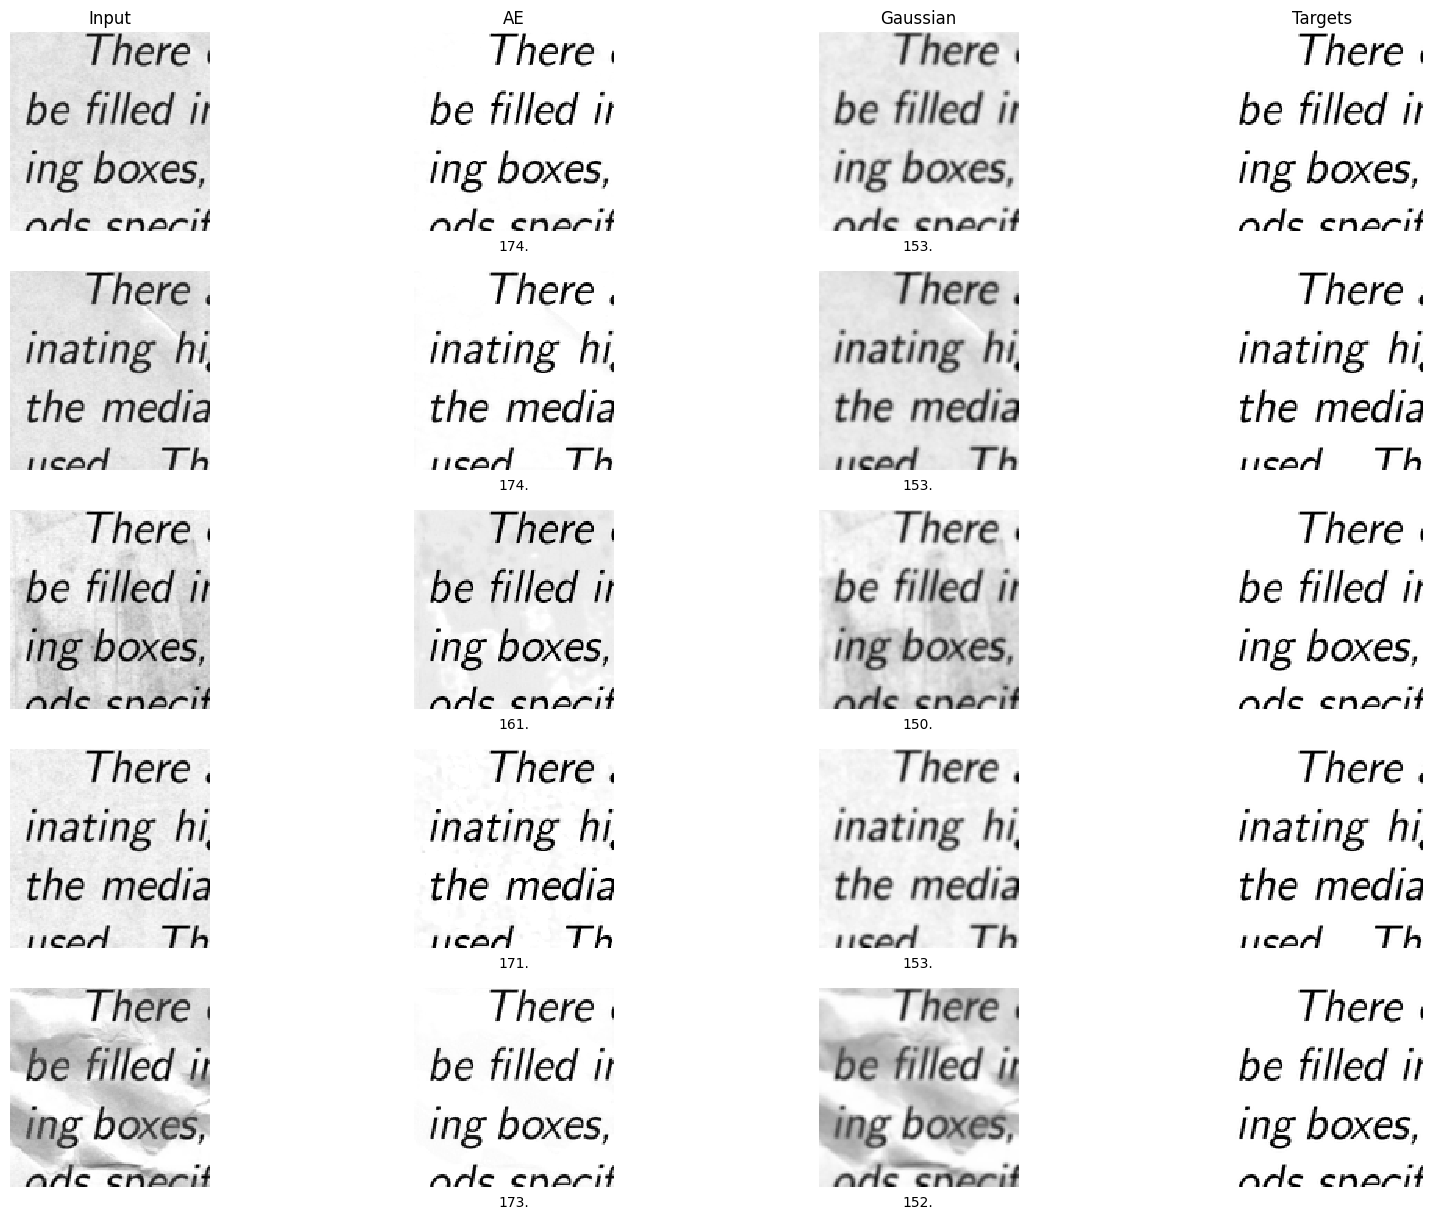

In [25]:
psnrs = [ 0.0 for el in targets ]
for i in range(len(tgts_plot)):
    psnr_ae = peak_signal_noise_ratio(tgts_plot[i], images_ae[i])
    pnsr_gauss = peak_signal_noise_ratio(tgts_plot[i], images_gauss[i])
    psnrs[i] = ['', psnr_ae, pnsr_gauss, '']

img = [imgs_plot, images_ae, images_gauss, tgts_plot]
titles = ['Input', 'AE', 'Gaussian', 'Targets']
texts = psnrs
plot_images_with_text(img, titles, texts)
plt.show()

**Question 4c**
<a name="question4c"></a>

#### Discuss which method performs better, and why, edit the cell below with "Your reply" ####

_Your reply here:_

AE method performs better

1. Gaussian Kernel Algorithm is actually one fixed convolutionary calculation which is linear. While AE method use deep layers of convolution and non-linear activation functions like ReLU/Sigmoid.

2. AE method uses dozens of convolution layers and  activation function which can collect and learn features of noise. For example, DnCNN learns the feature of noises and output denoised image by minus learned noise from origin image.

## 5. Implicit Neural Representation (30 points)
The objective here is to learn an implicit neural function to predict frames of an animated 2D object. That is, learn a function $f(x,y,t; \theta)$, where $\theta$ are learnable MLP weights, that takes as input pixel coordinates $x,y$ and time $t$ and predicts the pixel value at that location and time. The learned function should then be able to generate frames of the video at any given instance $t$. The task is divided into multiple incremental blocks as below:

[a)](#question5a) Fit an MLP model to a _single_ image. **(5 points)**

[b)](#question5b) Add positional encoding of pixels to improve prediction. **(5 points)**

[c)](#question5c) Adapt the framework to train an MLP to fit a sequence of frames instead of a single frame. **(8 points)**

[d)](#question5d) Fit the MLP to the sequence of frames with and without positional encoding on time, and report the result for both **(2 points)**

[e)](#question5e) Implement batching, to prevent memory issues when evaluating large number of pixels with the MLP. Size of a batch should not exceed 16000 **(5 points)**

[f)](#question5f) Generate a video of 100 frames uniformly sampled between the first and last frame. Since you trained on only 11 frames, by generating 100 frames you're interpolating unseen video frames. If your method works correctly, it should produce a continuous motion. If you overfit on the training frames, then it would give a discontinuous or jagged motion **(5 points)**


**Let's Prepare the animation inputs**

In [ ]:
!wget 'https://upload.wikimedia.org/wikipedia/commons/0/07/The_Horse_in_Motion-anim.gif'

X = np.zeros((11,230,340),dtype=np.uint8)
with imageio.get_reader('The_Horse_in_Motion-anim.gif') as r:
    for i in range(11):
        X[i] = r.get_data(i)
        X[i,0:20] = 255
        X[i,200:] = 255
        X[i,:,300:] = 255
        X[i,:,:10] = 255

X_resized = np.stack([cv2.resize(X[k], (128,128), cv2.INTER_AREA) for k in range(X.shape[0])], axis=0)
for i in range(X_resized.shape[0]):
  X_resized[i] = np.where(X_resized[i]>60,0,1)

--2023-11-11 16:54:23--  https://upload.wikimedia.org/wikipedia/commons/0/07/The_Horse_in_Motion-anim.gif
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 648978 (634K) [image/gif]
Saving to: ‘The_Horse_in_Motion-anim.gif’

The_Horse_in_Motion 100%[===================>] 633.77K  3.65MB/s    in 0.2s    

2023-11-11 16:54:23 (3.65 MB/s) - ‘The_Horse_in_Motion-anim.gif’ saved [648978/648978]



Let's visualize the frames:

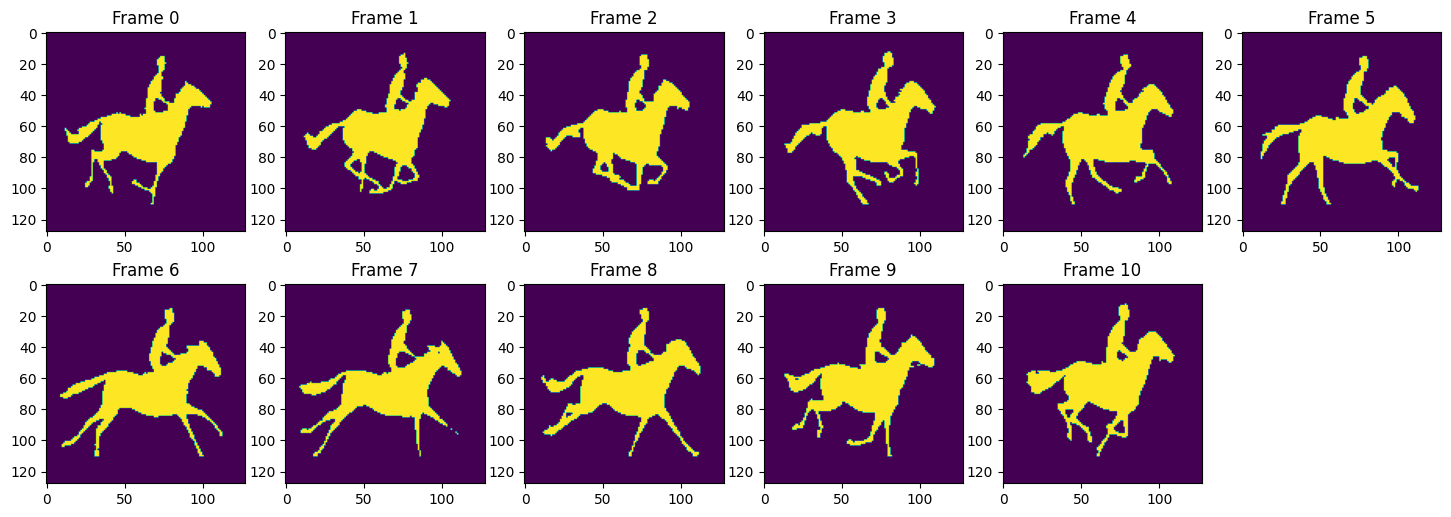

In [ ]:
plt.figure(figsize=(6*3,2*3))
for i in range(11):
    plt.subplot(2,6,i+1)
    plt.imshow(X_resized[i])
    plt.title(f'Frame {i}')
plt.show()
plt.close()

Save the frames as a video sequence

In [ ]:
output_path = 'input_bw_video.mp4'
with imageio.get_writer(output_path, mode='I', fps=10) as writer:
        for k in range(X_resized.shape[0]):
            writer.append_data(255*X_resized[k])
Video(output_path)

Visualization util method

In [ ]:
def plot_implicit_representation_single_image(image, model, device='cuda'):

    '''
    Visualize implicit representation of image from training the MLP model

    Args:
        - image TORCHFLOAT32 (H,W)
        - model MLP model which takes as input batches (BATCH,K) and return pixel prediction of dim (BATCH,1)
    '''

    with torch.no_grad():
        U = predict_image(image, model, device='cuda')
    U = U.reshape((1,image.shape[0],image.shape[1]))
    U_bw = (U>0.5).type(torch.int32).cpu()

    plt.figure(figsize=(12,6))

    plt.subplot(1,3,1)
    plt.title('Implicit rep.')
    plt.imshow(U[0].cpu().numpy())
    plt.colorbar()
    plt.clim(0,1)

    plt.subplot(1,3,2)
    plt.imshow(U_bw[0].cpu().numpy())
    plt.title('Prediction')

    plt.subplot(1,3,3)
    plt.imshow(image.cpu())
    plt.title('Ground truth')

def plot_implicit_representation_multi_images(images, model, device='cuda'):

    '''
    Visualize implicit representation of a set of images from training the MLP model

    Args:
        - images TORCHFLOAT32 (N,H,W)
        - model MLP model which takes as input batches (BATCH,K) and return pixel prediction of dim (BATCH,1)
    '''

    with torch.no_grad():
        U = predict_images(images, model, device='cuda')
    U = U.reshape((images.shape[0],images.shape[1],images.shape[2])).cpu()
    U_bw = (U>0.5).type(torch.int32).cpu()

    for i in range(images.shape[0]):

        plt.figure(figsize=(12,6))

        plt.subplot(1,3,1)
        plt.title('Implicit rep.')
        plt.imshow(U[i].cpu().numpy())
        plt.colorbar()
        plt.clim(0,1)

        plt.subplot(1,3,2)
        plt.imshow(U_bw[i].cpu().numpy())
        plt.title('Prediction')

        plt.subplot(1,3,3)
        plt.imshow(images[i].cpu())
        plt.title(f'Ground truth Frame {i}')

def plot_loss_and_accuracy(loss_list,accuracy_list):
    plt.figure(figsize=(8*2,6))

    plt.subplot(1,2,1)
    plt.plot([x[0] for x in loss_list], [x[1] for x in loss_list])
    plt.title('Training loss')
    plt.xlabel('epochs')

    plt.subplot(1,2,2)
    plt.plot([x[0] for x in accuracy_list], [x[1] for x in accuracy_list])
    plt.title('Accuracy')
    plt.ylim(0.,1.)
    plt.xlabel('epochs')

**Question 5a**
<a name='question5a'></a>

Fit an MLP model to a single image

Below, write a MLP model which takes as input a pixel position (x,y) and return a pixel value prediction $p_{x,y}$

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
class MLP(nn.Module):
    '''
    MLP class
    '''
    def __init__(self,input_dimension, nb_layers, embedding_dimension, output_dimension):
        super(MLP, self).__init__()

        #begin_solution
        self.nb_layers = nb_layers
        self.layers = []
        # MLP consists multiple layers of fully connection and activation function
        self.layers.append(nn.Linear(input_dimension, embedding_dimension))
        self.layers.append(nn.ReLU())
        for _ in range(self.nb_layers):
          self.layers.append(nn.Linear(embedding_dimension, embedding_dimension))
          self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(embedding_dimension, output_dimension))

        self.mlp = nn.Sequential(*self.layers)
        #end_solution


    def forward(self, input):
        #begin_solution
        prediction = self.mlp(input)
        # Add sigmoid after the last Linear layer to normalize the output
        # When using BCELoss, the output should be in [0.0, 1.0]
        prediction = 1 - (1 / (1 + torch.exp(-prediction)))

        #end_solution

        return prediction

Write a function which samples random pixel positions in an image

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
## Sample random pixel positions
def sample_image(image, n, scaled=True):
  '''
  Args:
    - image TORCHINT32 (H, W)
    - n : int, number of positions to sample
    - scaled: bool, if True, divide by the dimension
  Returns:
    - sampled_positions TORCHFLOAT32 ((n,2)), sampled positions
    - pixel_values TORCHINT32((n,)), sampled pixel values
  '''

  #begin_solution
  sampled_positions = []
  pixel_values = []
  H, W = image.shape
  image = image.numpy()
  # Randomly choose n points without repetition
  idx = [i for i in range(H * W)]
  selected_idx = random.sample(idx, n)

  points = np.zeros((H*W, 2)).astype(np.float32)
  values = np.zeros((H*W)).astype(np.float32)
  count = 0
  for i in range(H):
    for j in range(W):
      points[count][0] = i
      points[count][1] = j
      values[count] = image[i][j]
      count += 1

  selected_points = points[selected_idx, :]
  if scaled:
    selected_points[:, 0] /= H-1
    selected_points[:, 1] /= W-1
  selected_values = values[selected_idx]

  sampled_positions = torch.Tensor(selected_points)
  pixel_values = torch.Tensor(selected_values)

  #end_solution


  return sampled_positions, pixel_values

Write a function that takes and image and a trained MLP and predicts all pixel values of the image. That is, for every $x,y$ in the given image, predict its pixel value with the MLP.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def predict_image(image, model, device='cuda', scale=True):
    '''
    Reconstruct the complete set of images from the overfitted MLP model

    Args:
    - images TORCH_INT32 (H, W)
    - model, takes as input a batch of pixel positions and return pixel value
    Return:
    - prediction TORCHFLOAT32 (H, W) [CPU]
    '''
    #begin_solution
    model.eval()
    image = image.to(device)
    model = model.to(device)
    H, W = image.shape
    # Construct all input points, similar to sample_image()
    points = np.zeros((H*W, 2)).astype(np.float32)
    count = 0
    for i in range(H):
        for j in range(W):
            points[count][0] = i
            points[count][1] = j
            count += 1
    if scale:
        points[:, 0] /= H-1
        points[:, 1] /= W-1
    input = torch.Tensor(points).to(device)
    with torch.no_grad():
        output = model(input)

    prediction = output.cpu().detach().squeeze().reshape((H, W))

    #end_solution


    return prediction

Write a function to evaluate the model's prediction performance

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
## Compute accuracy over the set of frames
def eval_accuracy(image, model, device='cuda'):
  '''
  Args:
    - images TORCH_INT32 (H, W)
    - model, takes as input a batch of pixel positions and return pixel value
  Return:
    - mean_accuracy FLOAT32
  '''

  #begin_solution
  prediction = predict_image(image, model, device=device, scale=True)
  H, W = image.shape
  for i in range(H):
    for j in range(W):
      # Set 0.5 as threshold to decide a pixel is 0 or 1
      prediction[i][j] = 0 if prediction[i][j] < 0.5 else 1
  correct_num = torch.sum(torch.eq(prediction.to(device), image.to(device))).item()
  accuracy = correct_num / (image.shape[0] * image.shape[1])
  #end_solution


  return accuracy

Write the training loop. Train for a suitable number of epochs and while training populate the lists loss_list and accuracy_list with scalar values. These lists can be used for plotting later.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
loss_list, accuracy_list = [], []

#begin_solution
torch.cuda.empty_cache()
image = torch.Tensor(X_resized[0])
H, W = image.shape

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# After fine tuning, 8 hidden layers and 64 linear layer size performs better.
model = MLP(input_dimension=2, nb_layers=8, embedding_dimension=64, output_dimension=1).to(device)
# Considering we are fitting binary image, use BCELoss is reasonable
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
batch_size = 128
epochs = 50

points, values = sample_image(image, 10000, scaled=True)
dataset = np.hstack((points, values.reshape(-1, 1)))
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in data_loader:
        input = batch[:, :2].to(device)
        values = batch[:, 2].to(device)
        output = model(input).squeeze()

        loss = loss_function(output, values)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() / len(data_loader)

    loss_list.append([epoch, total_loss])
    accuracy = eval_accuracy(image.to(device), model, device=device)
    accuracy_list.append([epoch, accuracy])

    print('Epoch', epoch, 'Loss', total_loss, 'Accuracy', accuracy)

#end_solution

Epoch 0 Loss 0.4711513291054136 Accuracy 0.85546875
Epoch 1 Loss 0.3052204861482486 Accuracy 0.85546875
Epoch 2 Loss 0.209784340820735 Accuracy 0.92724609375
Epoch 3 Loss 0.17961804182091848 Accuracy 0.93280029296875
Epoch 4 Loss 0.16430645549221878 Accuracy 0.93115234375
Epoch 5 Loss 0.1596262091888657 Accuracy 0.93792724609375
Epoch 6 Loss 0.1560952419155761 Accuracy 0.9381103515625
Epoch 7 Loss 0.15274886650186553 Accuracy 0.9398193359375
Epoch 8 Loss 0.1510868443152572 Accuracy 0.935791015625
Epoch 9 Loss 0.14917217548700826 Accuracy 0.9365234375
Epoch 10 Loss 0.14579042518817925 Accuracy 0.94012451171875
Epoch 11 Loss 0.14487348232842692 Accuracy 0.9256591796875
Epoch 12 Loss 0.14758547079525416 Accuracy 0.939208984375
Epoch 13 Loss 0.1410845852445198 Accuracy 0.9425048828125
Epoch 14 Loss 0.13891220045617864 Accuracy 0.9427490234375
Epoch 15 Loss 0.13867165459484995 Accuracy 0.94268798828125
Epoch 16 Loss 0.13954755701596225 Accuracy 0.9365234375
Epoch 17 Loss 0.14786440888537639

Save the model (needed for marking)

In [ ]:
if not os.path.exists("models/"):
  os.makedirs("./models/")
torch.save({"model":model}, "models/implicit_single_image.pth")

Load the trained model

In [ ]:
state_dict = torch.load("models/implicit_single_image.pth")
model = state_dict["model"].to(device)

Let's plot our performance

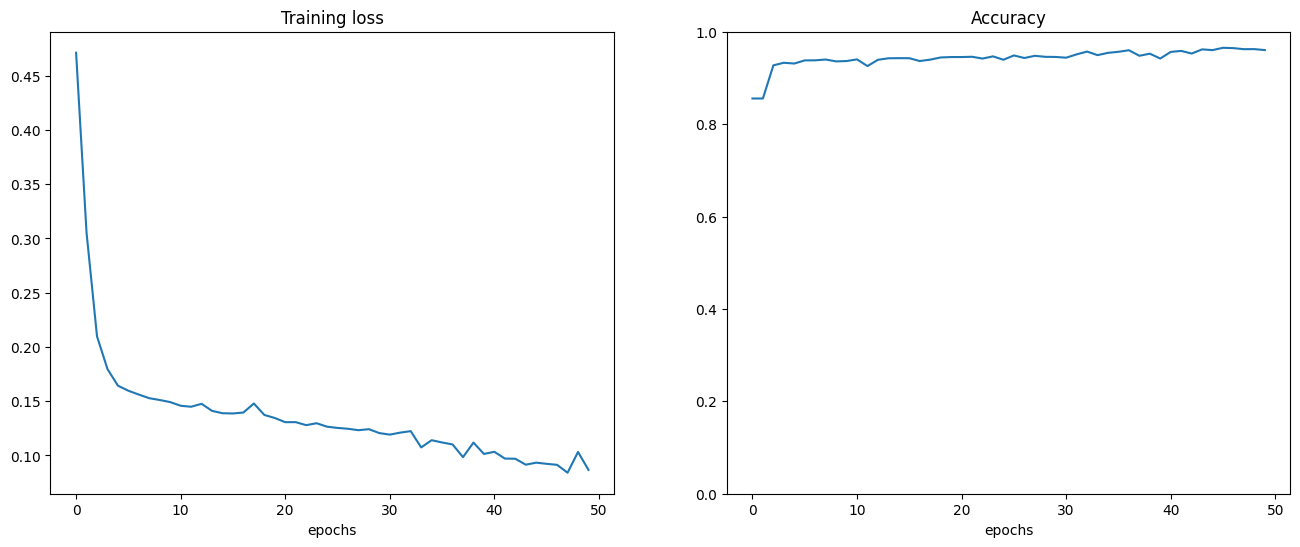

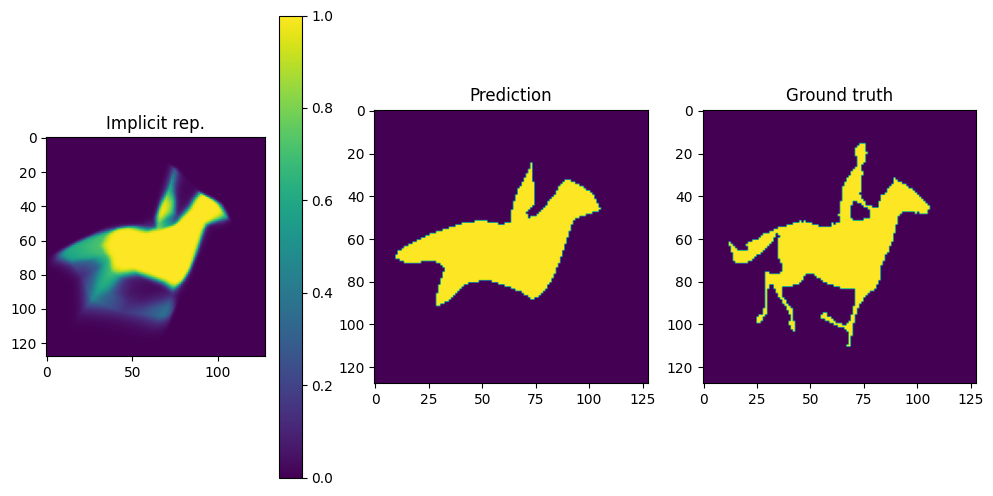

In [ ]:
plot_loss_and_accuracy(loss_list,accuracy_list)
plot_implicit_representation_single_image(image, model, device=device)

**Question 5b**
<a name='question5b'></a>

Add positional encoding of pixels to improve predictions.

Write a function that positionally encodes the input.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def positional_embedding_power_ls(X,L, cst=torch.pi):
    #begin_solution
    tmp = 2 ** torch.arange(L) * cst
    tmp = X.unsqueeze(2) * tmp.to(X.device)
    tmp = tmp.reshape((tmp.shape[0], -1))
    sin_encoding = torch.sin(tmp)
    cos_encoding = torch.cos(tmp)
    #end_solution

    return torch.cat([cos_encoding,sin_encoding], axis=-1)

Write a new MLP, while reusing the previous MLP model, that can predict using the positionally encoded pixel locations.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
class MLP_PE(nn.Module):
    '''
    MLP with positional encoding class
    '''
    def __init__(self,input_dimension, nb_layers, embedding_dimension, output_dimension, positional_enc_L=0):
        super(MLP_PE, self).__init__()
        #begin_solution
        self.nb_layers = nb_layers
        self.positional_enc_L = positional_enc_L
        # When implementing PE, the input dimension will be changed
        self.input_dimension = 2 * input_dimension * positional_enc_L
        self.layers = []

        self.layers.append(nn.Linear(self.input_dimension, embedding_dimension))
        self.layers.append(nn.ReLU())
        for _ in range(self.nb_layers):
            self.layers.append(nn.Linear(embedding_dimension, embedding_dimension))
            self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(embedding_dimension, output_dimension))

        self.mlp = nn.Sequential(*self.layers)
        #end_solution


    def forward(self, input):

        #begin_solution
        X = positional_embedding_power_ls(input, self.positional_enc_L, cst=torch.pi)
        prediction = self.mlp(X)
        prediction = 1 - (1 / (1 + torch.exp(-prediction)))
        #end_solution


        return prediction

Write the training loop similar to before. Train for a suitable number of epochs and while training populate the lists loss_list and accuracy_list with scalar values. These lists can be used for plotting later.

In [ ]:
loss_list, accuracy_list = [], []

#begin_solution
torch.cuda.empty_cache()
image = torch.Tensor(X_resized[0])
H, W = image.shape

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP_PE(input_dimension=2, nb_layers=8, embedding_dimension=64, output_dimension=1, positional_enc_L=10).to(device)
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
batch_size = 128
epochs = 50

points, values = sample_image(image, H * W, scaled=True)
dataset = np.hstack((points, values.reshape(-1, 1)))
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in data_loader:
        input = batch[:, :2].to(device)
        values = batch[:, 2].to(device)
        output = model(input).squeeze()

        loss = loss_function(output, values)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() / len(data_loader)

    loss_list.append([epoch, total_loss])
    accuracy = eval_accuracy(image.to(device), model, device=device)
    accuracy_list.append([epoch, accuracy])

    print('Epoch', epoch, 'Loss', total_loss, 'Accuracy', accuracy)
#end_solution

Epoch 0 Loss 0.3320716171292588 Accuracy 0.85546875
Epoch 1 Loss 0.1298634356353432 Accuracy 0.962158203125
Epoch 2 Loss 0.08013607391330879 Accuracy 0.97265625
Epoch 3 Loss 0.06062635705166031 Accuracy 0.97979736328125
Epoch 4 Loss 0.044273359249928035 Accuracy 0.98486328125
Epoch 5 Loss 0.03820313522373908 Accuracy 0.98895263671875
Epoch 6 Loss 0.033634194816841045 Accuracy 0.993408203125
Epoch 7 Loss 0.027909827729672543 Accuracy 0.99359130859375
Epoch 8 Loss 0.02237462954599323 Accuracy 0.9903564453125
Epoch 9 Loss 0.021011722870753147 Accuracy 0.9921875
Epoch 10 Loss 0.019942364939197432 Accuracy 0.99298095703125
Epoch 11 Loss 0.02186346012285867 Accuracy 0.99560546875
Epoch 12 Loss 0.013935889333765772 Accuracy 0.99395751953125
Epoch 13 Loss 0.015115688948071693 Accuracy 0.99664306640625
Epoch 14 Loss 0.01281370885050137 Accuracy 0.9964599609375
Epoch 15 Loss 0.013342830552744545 Accuracy 0.9969482421875
Epoch 16 Loss 0.011549264449627117 Accuracy 0.99530029296875
Epoch 17 Loss 0

Save the model (needed for marking)

In [ ]:
if not os.path.exists("models/"):
  os.makedirs("./models/")
torch.save({"model":model}, "models/implicit_single_image_positional_encoding.pth")

Load the trained model

In [ ]:
state_dict = torch.load("models/implicit_single_image_positional_encoding.pth")
model = state_dict["model"].to(device)

Let's plot our performance.

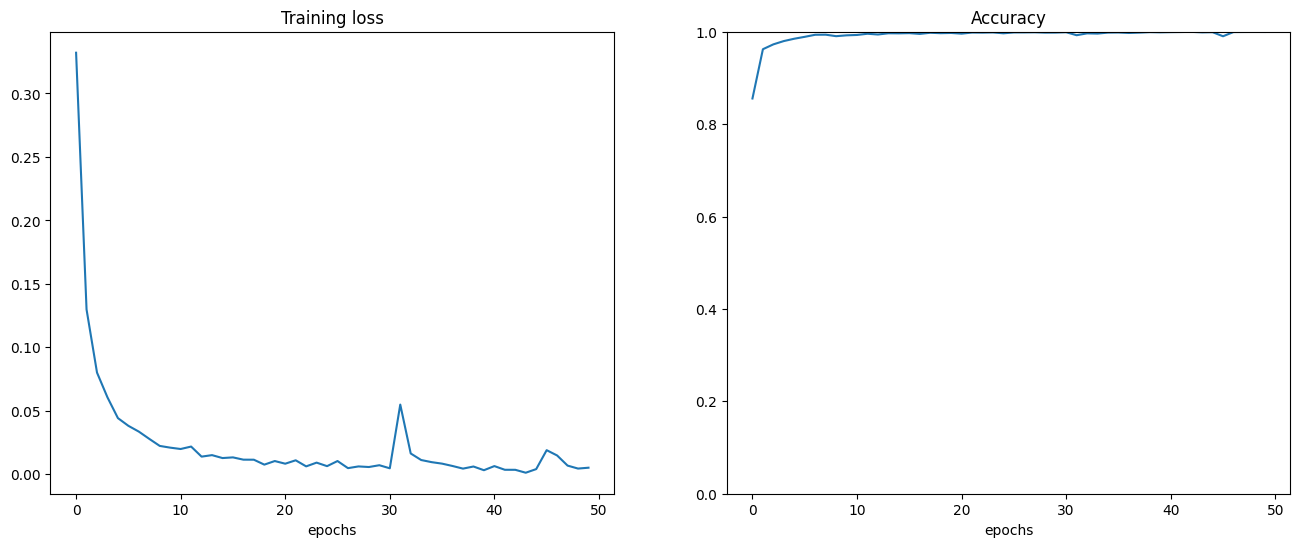

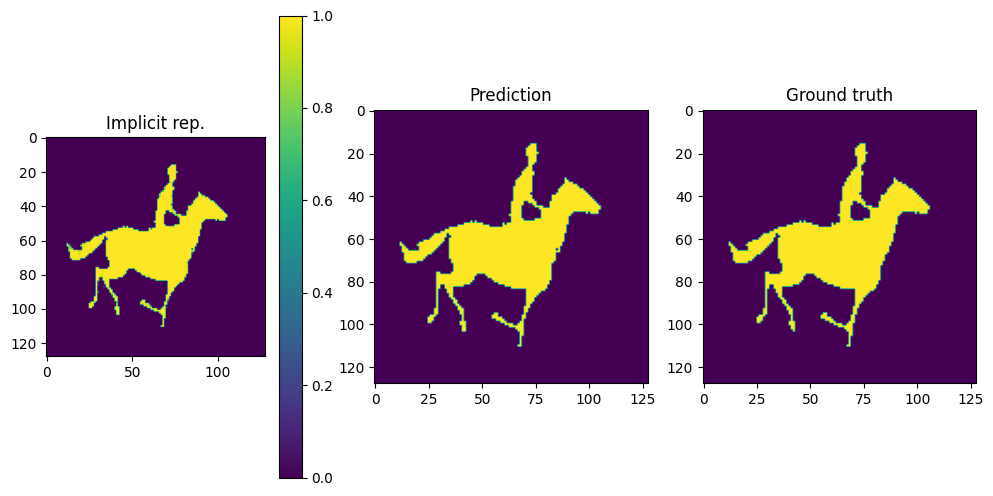

In [ ]:
plot_loss_and_accuracy(loss_list,accuracy_list)
plot_implicit_representation_single_image(image, model, device='cuda')

**Question 5c**
<a name='question5c'></a>

Adapt the framework to train an MLP to fit a sequence of frames instead of a single frame. You'd need to rewrite image sampling and other functions to achieve this.

Write a function that can now also sample across the time dimension.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def sample_images(images, n, scaled=True):
  '''
  Args:
    - images TORCHINT32 (N_frames, H, W)
    - n : int, number of positions to sample
    - scaled: bool, if True, divide by the dimension
  Returns:
    - sampled_positions TORCHFLOAT32 ((n,3)), sampled positions
    - pixel_values TORCHINT32((n,)), sampled pixel values
  '''

  #begin_solution
  sampled_positions = []
  pixel_values = []
  N, H, W = images.shape
  images = images.numpy()

  idx = [i for i in range(N * H * W)]
  selected_idx = random.sample(idx, n)
  # Different from single image, need to include time axis
  points = np.zeros((N*H*W, 3)).astype(np.float32)
  values = np.zeros((N*H*W)).astype(np.float32)
  count = 0
  for i in range(N):
      for j in range(H):
         for k in range(W):
            points[count][0] = j
            points[count][1] = k
            points[count][2] = i
            values[count] = images[i][j][k]
            count += 1

  selected_points = points[selected_idx, :]
  if scaled:
    selected_points[:, 0] /= H-1
    selected_points[:, 1] /= W-1
    selected_points[:, 2] /= N-1
  selected_values = values[selected_idx]

  sampled_positions = torch.Tensor(selected_points)
  pixel_values = torch.Tensor(selected_values)
  #end_solution

  return sampled_positions, pixel_values


Write a function to predict the images, now also across time.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def predict_images(images, model, device='cuda', scale=True):
  '''
  Reconstruct the complete set of images from the overfitted MLP model

  Args:
    - images TORCH_INT32 (N_frames, H, W)
    - model, takes as input a batch of pixel positions (K,2) and return pixel value (K,1)
  Return:
    - prediction TORCHFLOAT32 (N_frames, H, W) [CPU]
  '''
  #begin_solution
  model.eval()
  images = images.to(device)
  model = model.to(device)
  N, H, W = images.shape
  points = np.zeros((N*H*W, 3)).astype(np.float32)
  count = 0
  for i in range(N):
      for j in range(H):
         for k in range(W):
            points[count][0] = j
            points[count][1] = k
            points[count][2] = i
            count += 1
  if scale:
      points[:, 0] /= H-1
      points[:, 1] /= W-1
      points[:, 2] /= N-1
  input = torch.Tensor(points).to(device)
  with torch.no_grad():
      output = model(input)

  prediction = output.cpu().detach().squeeze().reshape((N, H, W))
  #end_solution


  return prediction

Write a function to evaluate performance across time.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
## Compute accuracy over the set of frames
def eval_mean_accuracy(images, model, device='cuda'):
  '''
  Args:
    - images TORCH_INT32 (N_frames, H, W)
    - model, takes as input a batch of pixel positions (K,2) and return pixel value (K,1)
  Return:
    - mean_accuracy FLOAT32
  '''
  #begin_solution
  prediction = predict_images(images, model, device=device, scale=True)
  N, H, W = images.shape
  for i in range(N):
      for j in range(H):
         for k in range(W):
            prediction[i][j][k] = 0 if prediction[i][j][k] < 0.5 else 1
  correct_num = torch.sum(torch.eq(prediction.to(device), images.to(device))).item()
  accuracy = correct_num / (N * W * H)
  #end_solution


  return accuracy

Write the training loop similar to before. Train for a suitable number of epochs and while training populate the lists loss_list and accuracy_list with scalar values. These lists can be used for plotting later.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
loss_list, accuracy_list = [], []

#begin_solution
torch.cuda.empty_cache()
images = torch.Tensor(X_resized)
N, H, W = images.shape

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_dimension=3, nb_layers=8, embedding_dimension=64, output_dimension=1).to(device)
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
batch_size = 128
epochs = 50

points, values = sample_images(images, 100000, scaled=True)
dataset = np.hstack((points, values.reshape(-1, 1)))
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in data_loader:
        input = batch[:, :3].to(device)
        values = batch[:, 3].to(device)
        output = model(input).squeeze()

        loss = loss_function(output, values)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() / len(data_loader)

    loss_list.append([epoch, total_loss])
    accuracy = eval_mean_accuracy(images.to(device), model, device=device)
    accuracy_list.append([epoch, accuracy])

    print('Epoch', epoch, 'Loss', total_loss, 'Accuracy', accuracy)

#end_solution


Epoch 0 Loss 0.26139880554831557 Accuracy 0.9158769087357954
Epoch 1 Loss 0.17598396181450462 Accuracy 0.9264359907670454
Epoch 2 Loss 0.15841679366500777 Accuracy 0.934814453125
Epoch 3 Loss 0.14636450348055136 Accuracy 0.9301924272017046
Epoch 4 Loss 0.13508074058462746 Accuracy 0.9463667436079546
Epoch 5 Loss 0.12427027658809485 Accuracy 0.9524092240767046
Epoch 6 Loss 0.116837379134372 Accuracy 0.9549560546875
Epoch 7 Loss 0.11533632686795182 Accuracy 0.9564319957386364
Epoch 8 Loss 0.10995329392459376 Accuracy 0.9533303000710227
Epoch 9 Loss 0.10550912488204292 Accuracy 0.9584738991477273
Epoch 10 Loss 0.10489951455227246 Accuracy 0.9569202769886364
Epoch 11 Loss 0.10251942904346907 Accuracy 0.9618807705965909
Epoch 12 Loss 0.09910301069545624 Accuracy 0.9576915394176136
Epoch 13 Loss 0.09865945745783544 Accuracy 0.9609430486505682
Epoch 14 Loss 0.0955112414729908 Accuracy 0.9627630060369318
Epoch 15 Loss 0.09514247976443575 Accuracy 0.96112060546875
Epoch 16 Loss 0.09373616869144

Save the model (needed for marking)

In [ ]:
if not os.path.exists("models/"):
  os.makedirs("./models/")
torch.save({"model":model}, "models/implicit_images_sequence.pth")

Load the trained model

In [ ]:
state_dict = torch.load("models/implicit_images_sequence.pth")
model = state_dict["model"].to(device)

Let's plot our performance

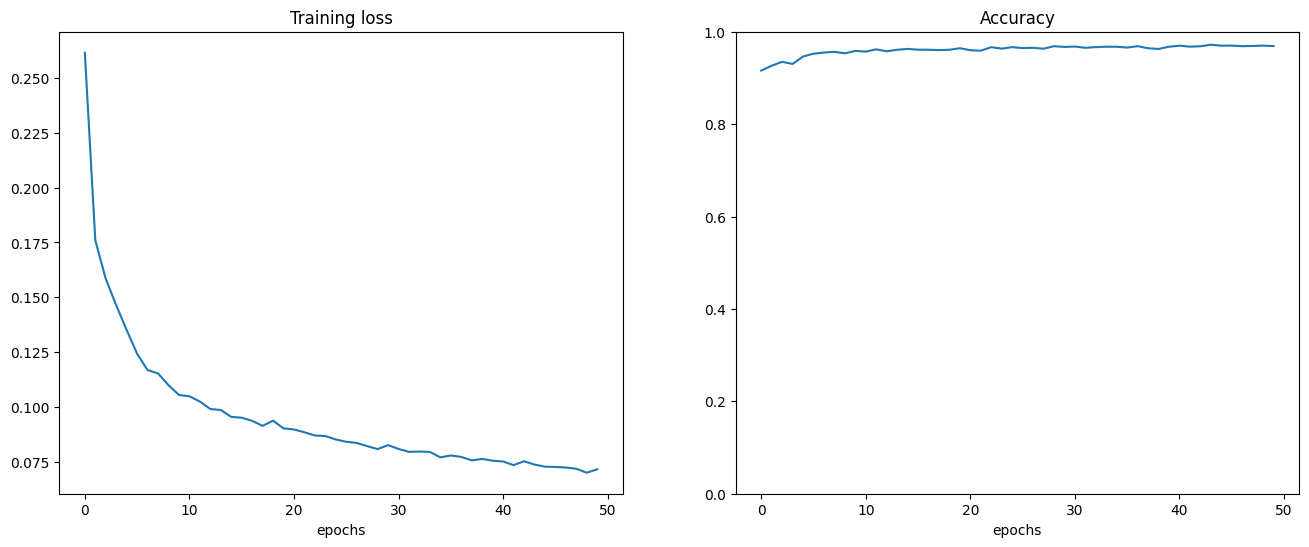

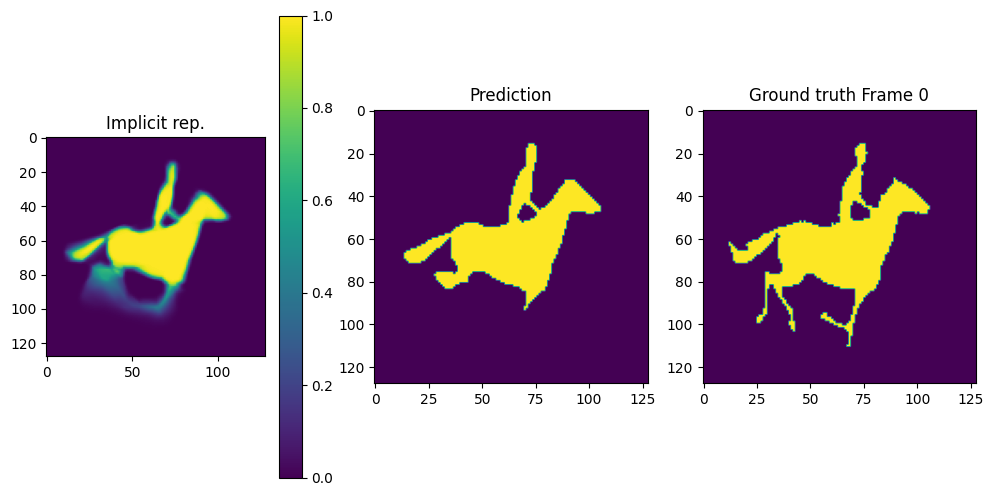

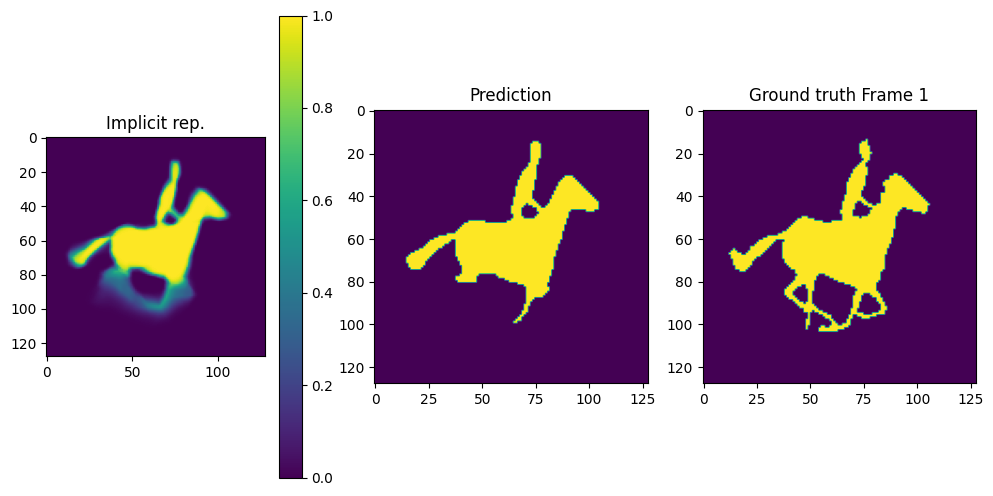

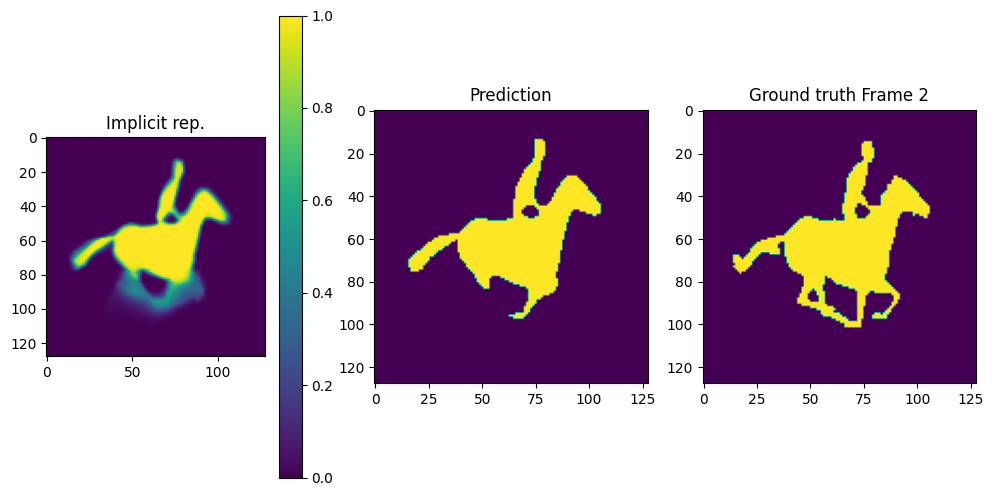

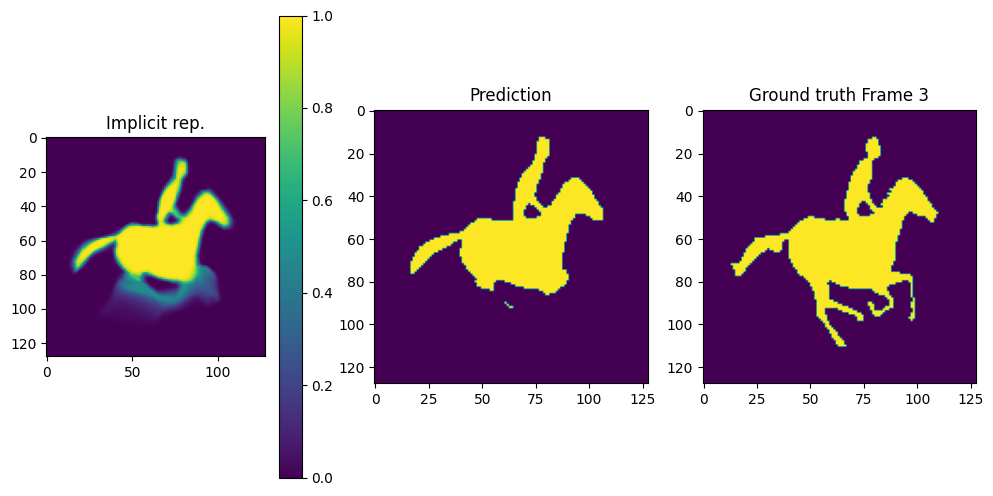

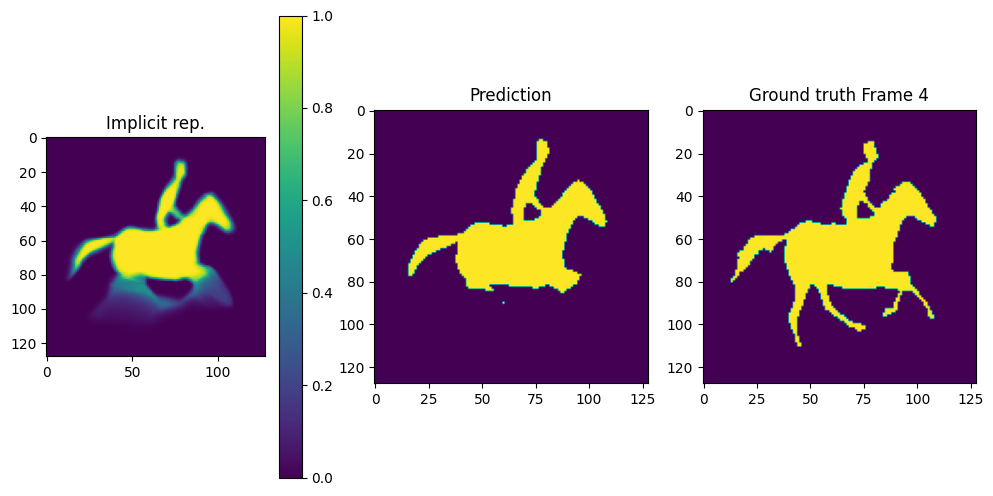

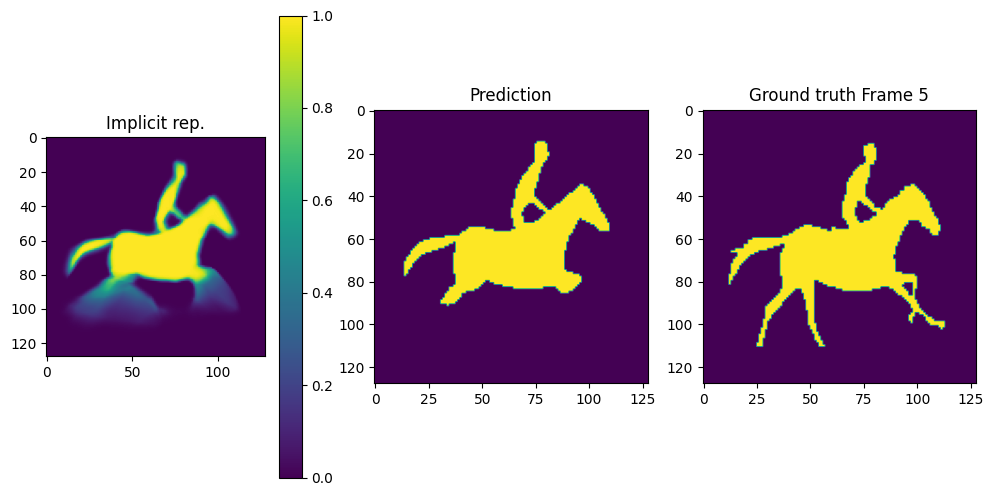

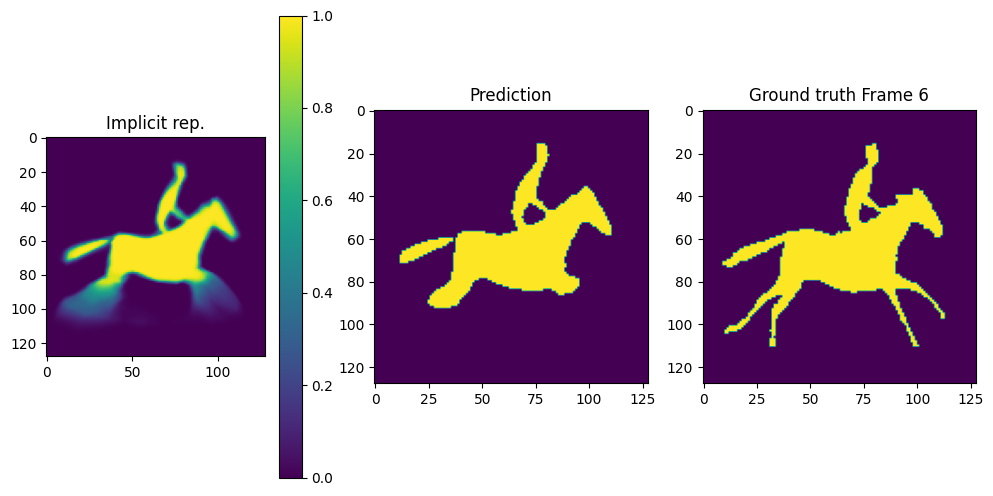

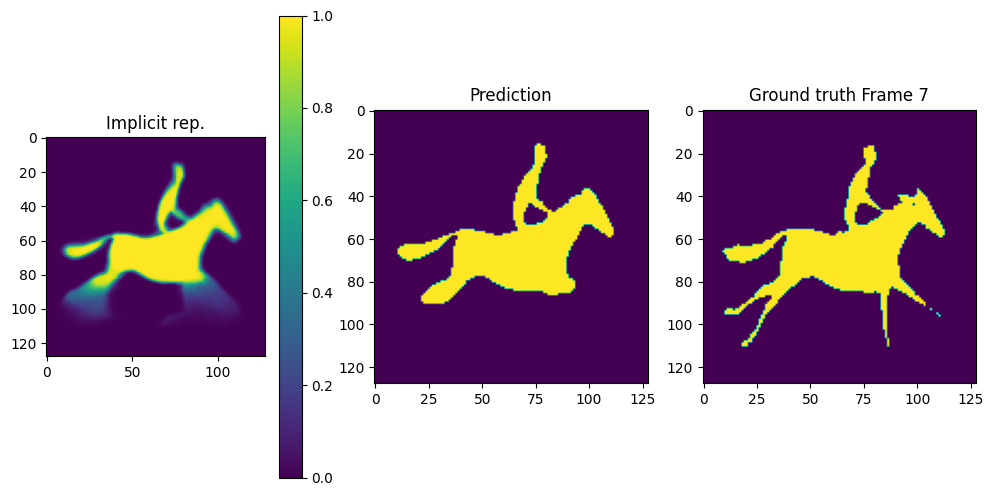

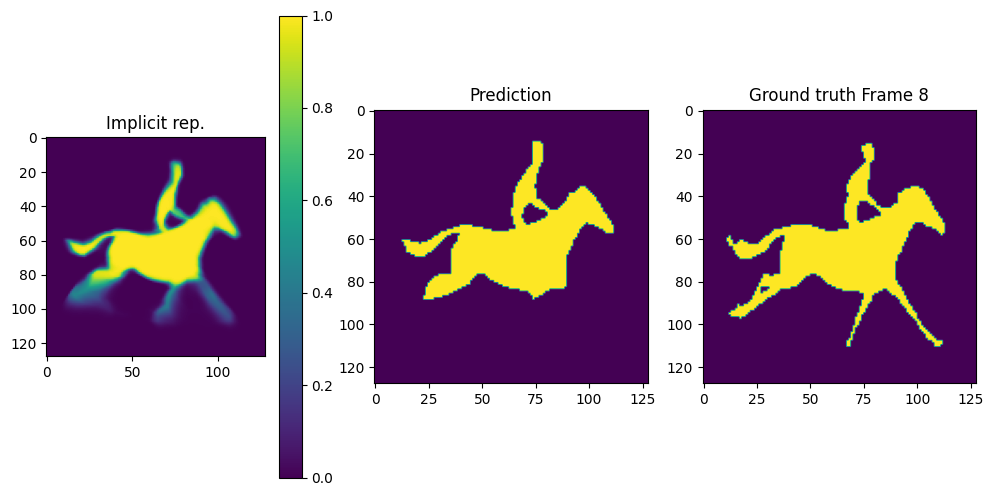

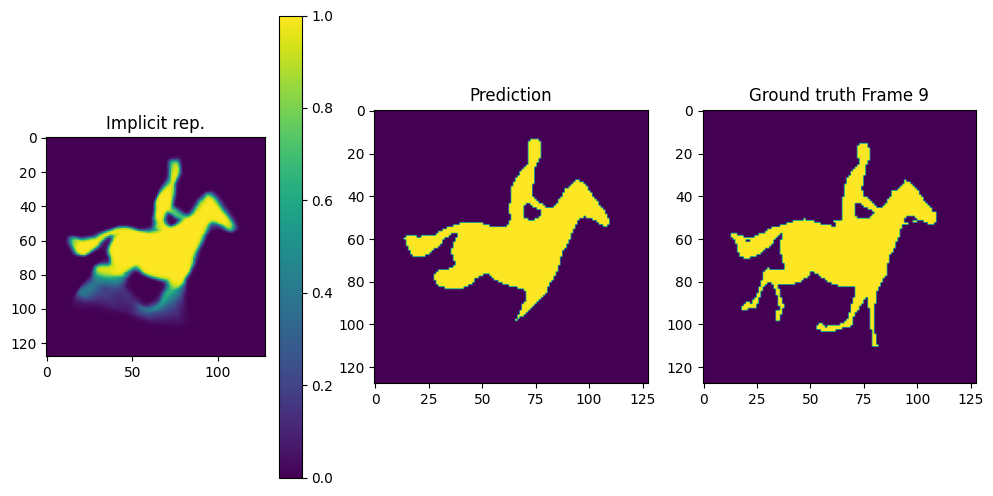

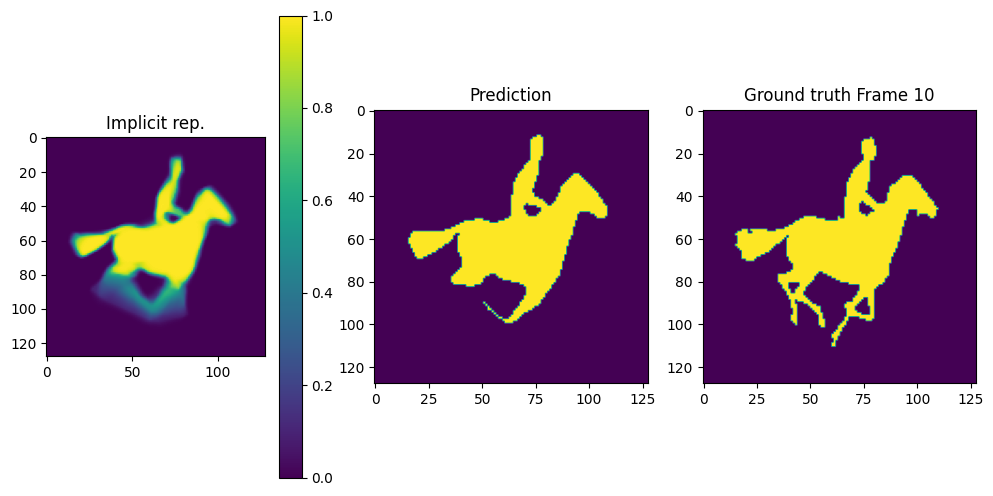

In [ ]:
plot_loss_and_accuracy(loss_list,accuracy_list)
plot_implicit_representation_multi_images(images, model, device=device)

**Question 5d**
<a name='question5d'></a>

Apply positional encoding for the time dimension.

Write a function that positionally encodes time values, with an optional flag to enable or disable it.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def positional_embedding_power_ls(X,L, cst=torch.pi, encode_time_dimension=True):
    #begin_solution
    if encode_time_dimension:
        tmp = 2 ** torch.arange(L) * cst
        tmp = X.unsqueeze(2) * tmp.to(X.device)
        tmp = tmp.reshape((tmp.shape[0], -1))
        sin_encoding = torch.sin(tmp)
        cos_encoding = torch.cos(tmp)
        encoding = torch.cat([cos_encoding,sin_encoding], axis=-1)
    else:
        tmp = 2 ** torch.arange(L) * cst
        tmp = X[:,:2].unsqueeze(2) * tmp.to(X.device)
        tmp = tmp.reshape((tmp.shape[0], -1))
        sin_encoding = torch.cos(tmp)
        cos_encoding = torch.cos(tmp)
        encoding = torch.cat([cos_encoding, sin_encoding, X[:, 2].unsqueeze(-1)], axis=-1)
    #end_solution

    return encoding

Write a new MLP, while re-using the previous one, that now predicts using the positionally encoded time. It should also predict without positional encoding, for comparison.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
class MLP_PE_time_option(nn.Module):
    '''
    MLP class
    '''
    def __init__(self,input_dimension, nb_layers, embedding_dimension, output_dimension,
                 positional_enc_L=0,encode_time_dimension=True):
        super(MLP_PE_time_option, self).__init__()
        #begin_solution
        self.nb_layers = nb_layers
        self.positional_enc_L = positional_enc_L
        self.encode_time_dimension = encode_time_dimension
        if encode_time_dimension:
            self.input_dimension = 2 * input_dimension * positional_enc_L
        else:
            self.input_dimension = 2 * (input_dimension - 1) * positional_enc_L + 1
        self.layers = []

        self.layers.append(nn.Linear(self.input_dimension, embedding_dimension))
        self.layers.append(nn.ReLU())
        for _ in range(self.nb_layers):
            self.layers.append(nn.Linear(embedding_dimension, embedding_dimension))
            self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(embedding_dimension, output_dimension))

        self.mlp = nn.Sequential(*self.layers)
        #end_solution


    def forward(self, input):
        #begin_solution
        X = positional_embedding_power_ls(input, self.positional_enc_L, cst=torch.pi, encode_time_dimension=self.encode_time_dimension)
        prediction = self.mlp(X)
        prediction = 1 - (1 / (1 + torch.exp(-prediction)))
        #end_solution

        return prediction


Write the training loop similar to before. Train for a suitable number of epochs and while training populate the lists loss_list and accuracy_list. These lists can be used for plotting later.

Note that this time, the two lists are nested. Each list should contain two sub-lists, one with Positional Encoding turned ON and other with Positional Encoding turned oFF. Each sub-list, similar to before, has scalar loss/acurracy values in each epoch.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
loss_list, accuracy_list = [[],[]], [[],[]]

# Assign your model to these variables depending on whether they have time encoding or not.
# We'll save these models to disk later
mlp_model_with_time_encoding = None
mlp_model_without_time_encoding = None

#begin_solution
torch.cuda.empty_cache()
images = torch.Tensor(X_resized)
N, H, W = images.shape

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp_model_with_time_encoding = MLP_PE_time_option(input_dimension=3,
                                                  nb_layers=8,
                                                  embedding_dimension=128,
                                                  output_dimension=1,
                                                  positional_enc_L=10,
                                                  encode_time_dimension=True).to(device)
mlp_model_without_time_encoding = MLP_PE_time_option(input_dimension=3,
                                                  nb_layers=8,
                                                  embedding_dimension=128,
                                                  output_dimension=1,
                                                  positional_enc_L=10,
                                                  encode_time_dimension=False).to(device)
loss_function = nn.BCELoss()
optimizer_1 = optim.Adam(mlp_model_with_time_encoding.parameters(), lr=0.0001)
optimizer_2 = optim.Adam(mlp_model_without_time_encoding.parameters(), lr=0.0001)
batch_size = 128
epochs_1 = 50
epochs_2 = 50

points, values = sample_images(images, N*W*H, scaled=True)
dataset = np.hstack((points, values.reshape(-1, 1)))
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
for epoch in range(epochs_1):
    mlp_model_with_time_encoding.train()
    total_loss_1 = 0

    for batch in data_loader:
        input = batch[:, :3].to(device)
        values = batch[:, 3].to(device)
        output_1 = mlp_model_with_time_encoding(input).squeeze()

        loss_1 = loss_function(output_1, values)
        optimizer_1.zero_grad()
        loss_1.backward()
        optimizer_1.step()

        total_loss_1 += loss_1.item() / len(data_loader)

    loss_list[0].append([epoch, total_loss_1])
    accuracy_1 = eval_mean_accuracy(images.to(device), mlp_model_with_time_encoding, device=device)
    accuracy_list[0].append([epoch, accuracy_1])

    print('TimeEncoding Epoch', epoch, 'Loss', total_loss_1, 'Accuracy', accuracy_1)

for epoch in range(epochs_2):
    mlp_model_without_time_encoding.train()
    total_loss_2 = 0

    for batch in data_loader:
        input = batch[:, :3].to(device)
        values = batch[:, 3].to(device)
        output_2 = mlp_model_without_time_encoding(input).squeeze()

        loss_2 = loss_function(output_2, values)
        optimizer_2.zero_grad()
        loss_2.backward()
        optimizer_2.step()

        total_loss_2 += loss_2.item() / len(data_loader)

    loss_list[1].append([epoch, total_loss_2])
    accuracy_2 = eval_mean_accuracy(images.to(device), mlp_model_without_time_encoding, device=device)
    accuracy_list[1].append([epoch, accuracy_2])

    print('NoTimeEncoding Epoch', epoch, 'Loss', total_loss_2, 'Accuracy', accuracy_2)
#end_solution


TimeEncoding Epoch 0 Loss 0.22590747979649536 Accuracy 0.9487415660511364
TimeEncoding Epoch 1 Loss 0.11853376064259052 Accuracy 0.9596668590198864
TimeEncoding Epoch 2 Loss 0.10035824819219265 Accuracy 0.9642389470880682
TimeEncoding Epoch 3 Loss 0.08892518806731636 Accuracy 0.9664861505681818
TimeEncoding Epoch 4 Loss 0.07937186325778543 Accuracy 0.9713301225142046
TimeEncoding Epoch 5 Loss 0.07095578413414347 Accuracy 0.9741321910511364
TimeEncoding Epoch 6 Loss 0.06364433792755748 Accuracy 0.9764959161931818
TimeEncoding Epoch 7 Loss 0.057251093311854344 Accuracy 0.9793756658380682
TimeEncoding Epoch 8 Loss 0.05204482657857375 Accuracy 0.9801857688210227
TimeEncoding Epoch 9 Loss 0.04710558525733761 Accuracy 0.9827325994318182
TimeEncoding Epoch 10 Loss 0.043378334165357635 Accuracy 0.98468017578125
TimeEncoding Epoch 11 Loss 0.04033122362207821 Accuracy 0.9839976917613636
TimeEncoding Epoch 12 Loss 0.03741329820199592 Accuracy 0.9863836115056818
TimeEncoding Epoch 13 Loss 0.034985

Save the model (needed for marking)

In [ ]:
if not os.path.exists("models/"):
  os.makedirs("./models/")
torch.save({"model":mlp_model_with_time_encoding}, "models/implicit_images_sequence_with_time_encoding.pth")
torch.save({"model":mlp_model_without_time_encoding}, "models/implicit_images_sequence_without_time_encoding.pth")

Let's plot both accuracies and loss curves.

Accuracy with time encoding : 0.997 without: 0.984


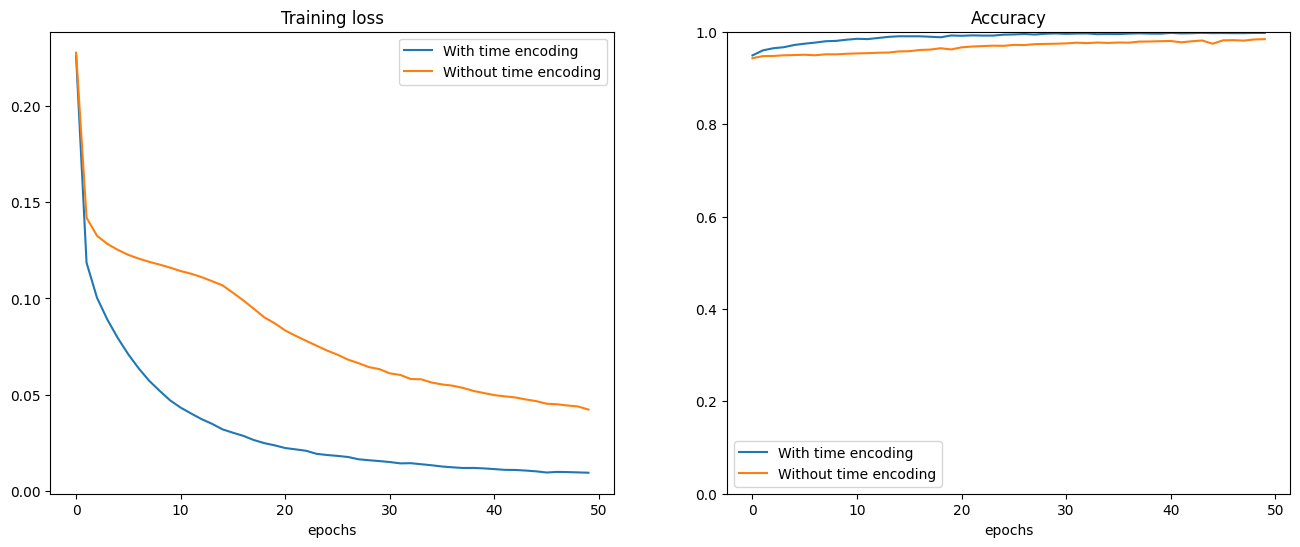

In [ ]:
plt.figure(figsize=(8*2,6))

plt.subplot(1,2,1)
plt.plot([x[0] for x in loss_list[0]], [x[1] for x in loss_list[0]], label='With time encoding')
plt.plot([x[0] for x in loss_list[1]], [x[1] for x in loss_list[1]], label='Without time encoding')
plt.title('Training loss')
plt.legend()
plt.xlabel('epochs')

plt.subplot(1,2,2)
plt.plot([x[0] for x in accuracy_list[0]], [x[1] for x in accuracy_list[0]], label='With time encoding')
plt.plot([x[0] for x in accuracy_list[1]], [x[1] for x in accuracy_list[1]], label='Without time encoding')
plt.title('Accuracy')
plt.ylim(0.,1.)
plt.xlabel('epochs')
plt.legend()

print('Accuracy with time encoding : {:.3f} without: {:.3f}'.format(accuracy_list[0][-1][1],accuracy_list[1][-1][1]))

**Question 5e**
<a name='question5e'></a>

Implement batching to prevent memory issues when evaluating large number of pixels with the MLP. Batch size should not exceed 16000.

Write a partition indexing function to create a list of partition indices that can be used to split the input into equal size chunks for prediction

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def partition_index(totalsize, chunksize):
    '''
    Args:
        - totalsize: int, Size of the batch to process
        - chunksize: int, subdivision to apply
    Return:
        - list_tuples: List, List of tuples (i,j) to process the batch in equal chunk
    '''
    #begin_solution
    list_tuples = []
    i = 0
    while i < totalsize:
        j = i + chunksize
        if j > totalsize:
            j = totalsize
        list_tuples.append((i, j))
        i = j
    #end_solution

    return list_tuples

Update image prediction to use the implemented batch partitioning

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def predict_images(images, model, device='cuda', scale=True):
  '''
  Reconstruct the complete set of images from the overfitted MLP model

  Args:
    - images TORCH_INT32 (N_frames, H, W)
    - model, takes as input a batch of pixel positions (K,2) and return pixel value (K,1)
  Return:
    - prediction TORCHFLOAT32 (N_frames, H, W) [CPU]
  '''
  #begin_solution
  model.eval()
  N, H, W = images.shape
  tmp = torch.where(images>=0)
  points = torch.vstack((tmp[1], tmp[2], tmp[0])).T
  prediction = []
  for start, end in partition_index(N*H*W, 64):
    batch = points[start : end].to(device).float()
    output = model(batch)
    prediction.append(output.cpu().detach().numpy().tolist())
  prediction = torch.Tensor(prediction).reshape(N, H, W)
  #end_solution


  return prediction


**Question 5f**
<a name='question5f'></a>

Write code to generate a video of 100 frames uniformly sampled between the first and last frame. Save the video as an MP4.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
output_path = 'result_bw_video.mp4'
#begin_solution
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
state_dict = torch.load("models/implicit_images_sequence_without_time_encoding.pth")
model = state_dict["model"].to(device)
model.eval()
N, H, W = 100, 128, 128
points = np.zeros((N*H*W, 3)).astype(np.float32)
count = 0
scale = True
for frame in range(N):
    for i in range(H):
        for j in range(W):
            points[count][0] = i
            points[count][1] = j
            points[count][2] = frame
            count += 1
if scale:
    points[:, 0] /= H-1
    points[:, 1] /= W-1
    points[:, 2] /= N-1
input = torch.Tensor(points).to(device)
with torch.no_grad():
    output = model(input)
prediction = output.cpu().detach().squeeze().reshape((N, H, W))

gen = prediction.numpy()
gen[gen < 0.5] = 0
gen[gen >= 0.5] = 1
gen = gen.astype(np.uint8)
with imageio.get_writer(output_path, mode='I', fps=30) as writer:
        for k in range(100):
            writer.append_data(255*gen[k])
#end_solution

Video(output_path)